# Introduction

Exploratory Data Analysis for the 5th Makridakis forecasting competitions (M5)! 

# Some Background 

The M-competitions, aim to provide a better understanding and advancement of forecasting methodology by comparing the performance of different methods in solving a well-defined, real-world problem. 

# The goal: 

We have been asked to forecast sales information for the next 28 days using data from the huge retailer Walmart. This contest will feature two tracks: In the Forecasting competition, we are tasked with predicting the values themselves, and in the Uncertainty Distribution competition, we are tasked with estimating the uncertainty of our forecasts. The 28-day forecast horizon is the same for both events.

The data: We are working with 42,840 hierarchical time series. The data were obtained in the 3 US states of California (CA), Texas (TX), and Wisconsin (WI). The term "hierarchical" in this context refers to the ability to combine data at several levels, including item, department, product category, and state. The sales data covers the period from January 2011 to June 2016. We are provided with relevant information on prices, promotions, and holidays in addition to the sales figures. Please take note that the majority of the time series have zero values, as advised.

The information includes 3049 distinct products sold in 10 stores across 3 states, distributed over 3 categories and 7 departments. The combinations of these factors are captured by the hierarchical aggregate. One time series might be made for all sales, three for all sales by state, and so on. The largest category is sales of all individual 3049 products per 10 stores for 30490 time series.

# The training data comes in the shape of 3 separate files:

sales_train.csv: this is our main training data. It has 1 column for each of the 1941 days from 2011-01-29 and 2016-05-22; not including the validation period of 28 days until 2016-06-19. It also includes the IDs for item, department, category, store, and state. The number of rows is 30490 for all combinations of 30490 items and 10 stores.

sell_prices.csv: the store and item IDs together with the sales price of the item as a weekly average.

calendar.csv: dates together with related features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0).

# The metrics:

The point forecast submission are being evaluated using the Root Mean Squared Scaled Error (RMSSE), which is derived from the Mean Absolute Scaled Error (MASE) that was designed to be scale invariant and symmetric. In a similar way to the MASE, the RMSSE is scale invariant and symmetric, and measures the prediction error (i.e. forecast - truth) relative to a “naive forecast” that simply assumes that step i = step i-1. In contrast to the MASE, here both prediction error and naive error are scaled to account for the goal of estimating average values in the presence of many zeros.

The uncertainy distributions are being evaluated using the Weighted Scaled Pinball Loss (WSPL). We are asked to provide the 50%, 67%, 95%, and 99% uncertainty intervals together with the forecasted median.

Both metrics are computed for each time series and then averaged accross all time series including weights. The weights are proportional to the sales volume of the item, in dollars, to give more importance to high selling products. Note, that the weights are based on the last 28 days of the training data, and that those dates will be adjusted for the ultimate evaluation data, as confirmed by the organisers.

### Hypothesis
Based on the data given some of the factors that may affect sales are:
1. Day- Customers shopping time and spending mostly depends on the weekend. Many customers may like to shop only at weekends.
2. Special Events/Holidays: Depending on the events and holidays customers purchasing behavior may change. For holidays like Easter, food sales may go up and for sporting events like Superbowl finals Household item sales may go up.
3. Product Price: The sales are affected the most by the product price. Most customers will check the price tag before making the final purchase.
4. Product Category: The type of product greatly affects sales. For instance, products in the household like TV will have fewer sales when compared with sales of food products.
5. Location: The location also plays an important role in sales. In states like California, the customers might buy products they want irrespective of price, and customers in another region may be price sensitive

Before diving deep into data exploration, A quick overview of population & Median Income for each state:

### California
Population: 39.51 Million
Median Household Annual Income: $75,277

### Texas
Population: 29 Million
Median Household Annual Income: $59,570

### Wisconsin
Population 5.822 Million
Median Income: $60,733
 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import time
import math
import datetime

import warnings


# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

from math import log, floor
from sklearn.neighbors import KDTree

import seaborn as sns
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

import itertools
from itertools import cycle
plt.style.use('seaborn')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import gc
from downcast import reduce

In [2]:
df_calendar = pd.read_csv('~/sales_data/calendar.csv')
df_sales_train = pd.read_csv('~/sales_data/sales_train_evaluation.csv')
df_sell_prices = pd.read_csv('~/sales_data/sell_prices.csv')
df_sample_submission = pd.read_csv('~/sales_data/sample_submission.csv')

In [3]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df_calendar = reduce_mem_usage(df_calendar)

df_sell_prices = reduce_mem_usage(df_sell_prices)

df_sales_train = reduce_mem_usage(df_sales_train)

df_sample_submission = reduce_mem_usage(df_sample_submission)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 96.13 Mb (78.8% reduction)
Mem. usage decreased to 26.47 Mb (84.5% reduction)


#  Quick Look: File structure and content

In [4]:
df_sales_train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  d_1935  d_1936  \
0       CA    0    0    0    0  ...       2       4       0       0       0   
1       CA    0    0    0    0  ...       0       1       2       1       1   
2       CA    0    0    0    0  ...       1       0       2       0       0   
3       CA    0    0    0    0  ...       1       1       0       4       0   
4       CA    0    0    0    0  ...       0       0       0       2       1   

   d_1937  d_1938  d_1939  d_1940  d_1941  
0       0       3       3       0       1  
1       0       0       0       0       0  
2       0       2       3       0       1  
3       1       3       0       2       6  
4       0       0       2       1       0  

[5 rows x 1947 columns]

In [5]:
df_sales_train.isna().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64

In [6]:
df_sales_train.describe()

d_1           d_2           d_3           d_4           d_5  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.070220      1.041292      0.780026      0.833454      0.627944   
std        5.126689      5.365468      3.667454      4.415141      3.379344   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      360.000000    436.000000    207.000000    323.000000    296.000000   

                d_6           d_7           d_8           d_9          d_10  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.958052      0.918662      1.244080      1.073663      0.838701   
std        4.785947      5.059495      6.617729      5.917204      4.206199   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      314.000000    316.000000    370.000000    385.000000    353.000000   

       ...        d_1932        d_1933        d_1934        d_1935  \
count  ...  30490.000000  30490.000000  30490.000000  30490.000000   
mean   ...      1.445490      1.781174      1.965267      1.389374   
std    ...      3.656824      4.426550      4.706284      3.313292   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      1.000000      1.000000      0.000000   
75%    ...      2.000000      2.000000      2.000000      2.000000   
max    ...    143.000000    156.000000    187.000000     98.000000   

             d_1936        d_1937        d_1938        d_1939        d_1940  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.271794      1.216661      1.212299      1.395605      1.689669   
std        3.126178      3.000348      2.955910      3.514318      4.089208   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      1.000000   
75%        1.000000      1.000000      1.000000      1.000000      2.000000   
max       90.000000     77.000000     84.000000    110.000000    156.000000   

             d_1941  
count  30490.000000  
mean       1.782158  
std        4.284356  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        2.000000  
max      117.000000  

[8 rows x 1941 columns]

In [7]:
print("shape of dataframe", df_sales_train.shape)
print("number of rows : ", df_sales_train.shape[0])
print("number of columns : ", df_sales_train.shape[1])

shape of dataframe (30490, 1947)
number of rows :  30490
number of columns :  1947


In [8]:
df_sales_train['item_id'].nunique()

3049

In [9]:
df_sales_train['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [10]:
len(df_sales_train)

30490

In [16]:
print(df_sales_train.dtypes)

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909        int8
d_1910        int8
d_1911       int16
d_1912       int16
d_1913       int16
Length: 1919, dtype: object


# Observations:

1. There is one column each for the IDs of item, department, category, store, and state; plus a general ID that is a combination of the other IDs plus a flag for validation.

2. The sales per date are encoded as columns starting with the prefix d_. Those are the number of units sold per day (not the total amount of dollars).

3. We already see that there are quite a lot of zero values.

In [17]:
df_sell_prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325    9.578125
1     CA_1  HOBBIES_1_001     11326    9.578125
2     CA_1  HOBBIES_1_001     11327    8.257812
3     CA_1  HOBBIES_1_001     11328    8.257812
4     CA_1  HOBBIES_1_001     11329    8.257812

In [14]:
df_sell_prices.describe().T

count          mean         std           min           25%  \
wm_yr_wk    6841121.0  11382.943423  148.610026  11101.000000  11247.000000   
sell_price  6841121.0           NaN    0.000000      0.010002      2.179688   

                     50%           75%         max  
wm_yr_wk    11411.000000  11517.000000  11621.0000  
sell_price      3.470703      5.839844    107.3125

# Observations:

1. We have the store_id and item_id to link this data to our training and validation data.

2. Prices range from $0.10 to a bit more than 100 dollars.

In [19]:
df_calendar.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [20]:
df_calendar.event_name_1.unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [21]:
df_calendar.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [22]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int16 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int8  
 4   month         1969 non-null   int8  
 5   year          1969 non-null   int16 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int8  
 12  snap_TX       1969 non-null   int8  
 13  snap_WI       1969 non-null   int8  
dtypes: int16(2), int8(5), object(7)
memory usage: 125.1+ KB


In [23]:
df_calendar.event_name_1.unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [24]:
df_calendar.event_type_1.unique()

array([nan, 'Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [25]:
df_calendar.event_name_2.unique()

array([nan, 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', "Father's day"],
      dtype=object)

In [26]:
df_calendar.event_type_2.unique()

array([nan, 'Cultural', 'Religious'], dtype=object)

In [27]:
# get all the event types

df_calendar.groupby('event_type_1')['date'].count()

event_type_1
Cultural     37
National     52
Religious    55
Sporting     18
Name: date, dtype: int64

In [28]:
df_calendar.groupby('event_type_2')['date'].count()

event_type_2
Cultural     4
Religious    1
Name: date, dtype: int64

In [29]:
# get all the event names

df_calendar.groupby('event_name_1')['date'].count()

event_name_1
Chanukah End           5
Christmas              5
Cinco De Mayo          5
ColumbusDay            5
Easter                 5
Eid al-Fitr            5
EidAlAdha              5
Father's day           4
Halloween              5
IndependenceDay        5
LaborDay               5
LentStart              6
LentWeek2              6
MartinLutherKingDay    5
MemorialDay            6
Mother's day           6
NBAFinalsEnd           6
NBAFinalsStart         6
NewYear                5
OrthodoxChristmas      5
OrthodoxEaster         5
Pesach End             6
PresidentsDay          6
Purim End              6
Ramadan starts         6
StPatricksDay          6
SuperBowl              6
Thanksgiving           5
ValentinesDay          6
VeteransDay            5
Name: date, dtype: int64

In [30]:
df_calendar.groupby('event_name_2')['date'].count()

event_name_2
Cinco De Mayo     1
Easter            1
Father's day      2
OrthodoxEaster    1
Name: date, dtype: int64

In [31]:
## check a few examples

df_calendar[df_calendar['event_name_1'] == 'NewYear']

date  wm_yr_wk    weekday  wday  month  year       d event_name_1  \
337   2012-01-01     11149     Sunday     2      1  2012   d_338      NewYear   
703   2013-01-01     11249    Tuesday     4      1  2013   d_704      NewYear   
1068  2014-01-01     11349  Wednesday     5      1  2014  d_1069      NewYear   
1433  2015-01-01     11448   Thursday     6      1  2015  d_1434      NewYear   
1798  2016-01-01     11548     Friday     7      1  2016  d_1799      NewYear   

     event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
337      National          NaN          NaN        1        1        0  
703      National          NaN          NaN        1        1        0  
1068     National          NaN          NaN        1        1        0  
1433     National          NaN          NaN        1        1        0  
1798     National          NaN          NaN        1        1        0

In [5]:
df_calendar.describe()

wm_yr_wk         wday        month         year      snap_CA  \
count   1969.000000  1969.000000  1969.000000  1969.000000  1969.000000   
mean   11347.086338     3.997461     6.325546  2013.288471     0.330117   
std      155.277043     2.001141     3.416864     1.580198     0.470374   
min    11101.000000     1.000000     1.000000  2011.000000     0.000000   
25%    11219.000000     2.000000     3.000000  2012.000000     0.000000   
50%    11337.000000     4.000000     6.000000  2013.000000     0.000000   
75%    11502.000000     6.000000     9.000000  2015.000000     1.000000   
max    11621.000000     7.000000    12.000000  2016.000000     1.000000   

           snap_TX      snap_WI  
count  1969.000000  1969.000000  
mean      0.330117     0.330117  
std       0.470374     0.470374  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000

In [33]:
len(df_calendar.wm_yr_wk.unique())

282

# Observations:

1. The calendar data gives us date features such as weekday, month, or year; alongside 2 different event features and a SNAP food stamps flag.

2. The calendar has all the relevant dates, weekdays, months plus snap binary flags and logical event columns.

3. There are only 5 non-NA rows in the event_name_2 column; i.e. only 5 (out of 1969) instances where there is more than 1 event on a particular day.

## *EDA (Exploratory Data Analysis):*

### Questions on distribution of product & behavior across timeline

Starting with the dataframe denoted by train_sales_df that has the item specific ('id'), locale specific ('store_id' , 'state_id') and sales days specific (d_1 to d_1913) information; let us first make necessary adjustments to separate the sales days so that analysis along item_id, store_id and dept_id can be more easily observed across sales days only. 

In [34]:
df_sales_train.head(3)

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  

[3 rows x 1919 columns]

In [7]:
d_cols = [c for c in df_sales_train.columns if 'd_' in c]
df_sales_train['total_sales_all_days'] = df_sales_train[d_cols].sum(axis = 1)
df_sales_train['avg_sales_all_days'] = df_sales_train[d_cols].mean(axis = 1)
df_sales_train['median_sales_all_days'] = df_sales_train[d_cols].median(axis = 1)
#train_sales_df.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

df_sales_train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1935  d_1936  d_1937  d_1938  d_1939  \
0       CA    0    0    0    0  ...       0       0       0       3       3   
1       CA    0    0    0    0  ...       1       1       0       0       0   
2       CA    0    0    0    0  ...       0       0       0       2       3   
3       CA    0    0    0    0  ...       4       0       1       3       0   
4       CA    0    0    0    0  ...       2       1       0       0       2   

   d_1940  d_1941  total_sales_all_days  avg_sales_all_days  \
0       0       1                   633            0.326121   
1       0       0                   500            0.257599   
2       0       1                   309            0.159196   
3       2       6                  3337            1.719217   
4       1       0                  1888            0.972694   

   median_sales_all_days  
0                    0.0  
1                    0.0  
2                    0.0  
3                    1.0  
4                    1.0  

[5 rows x 1950 columns]

#### Distribution of product_ids across categories?

In [9]:
df = df_sales_train.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
fig = px.pie(df, values='total_entries', names='cat_id', 
            color_discrete_sequence=px.colors.sequential.RdBu,
            width = 750, height=450, title = 'Distribution of product_IDs across categories')
fig.show()

Food items are the most sold out item that are followed by household items and then hobbies items.

In [11]:
def total_sales_dist(df):
    df = df_sales_train.groupby(['state_id'])['total_sales_all_days'].sum().reset_index()
    fig = px.pie(df, values='total_sales_all_days', names='state_id',
                 #color_discrete_sequence=px.colors.sequential.Aggrnyl,
                 width = 750, height=450, title = 'Distribution of Total_Sales Across States')
    fig.show()
    
total_sales_dist(df_sales_train)

With respect to the total number of sales, it is evident once again that the number of items sold on total have the greatest contributing share in CA, followed by Texas and Wisconsin. Now is it the case with the total revenue generated as well? We'd find that out using the revenue dataframe 

In [12]:
df1 = df_sales_train.groupby(['cat_id'])['id'].count().reset_index(name='total_entries')
df2 = df_sales_train.groupby(['cat_id', 'state_id'])['total_sales_all_days'].sum().reset_index()

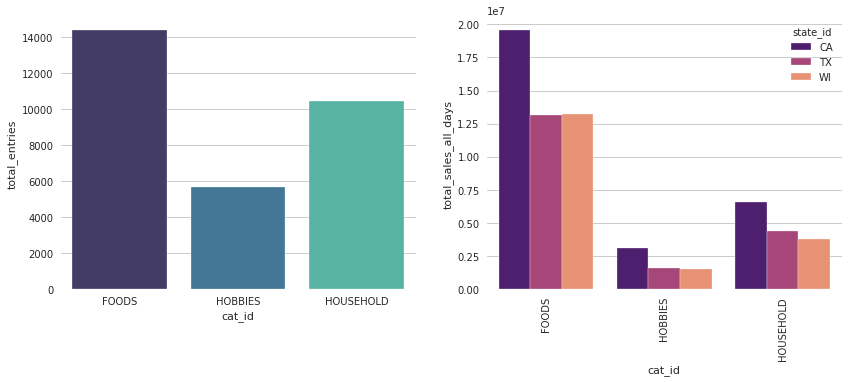

<Figure size 432x288 with 0 Axes>

In [15]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'cat_id', y='total_entries', data=df1, 
            palette='mako', ax=ax1)
sns.barplot(x = 'cat_id', y='total_sales_all_days', hue='state_id', data=df2, 
            palette='magma', ax=ax2)

plt.xticks(rotation=90)
plt.show()
plt.savefig('total_sales_by_category')

The above two plots indicate:
- Most items sold belong to the FOODS category, followed by HOUSEHOLD and HOBBIES
- CA leads in the number of "Total items" sold in either category (FOODS, HOBBIES AND HOUSEHOLD) , while WISCONSIN lags behind TX in each category except FOODS. We would see whether the same difference translates in terms of revenue extracted off these states or not

In [40]:
df3 = df_sales_train.groupby(['cat_id', 'store_id'])['total_sales_all_days'].sum().reset_index()

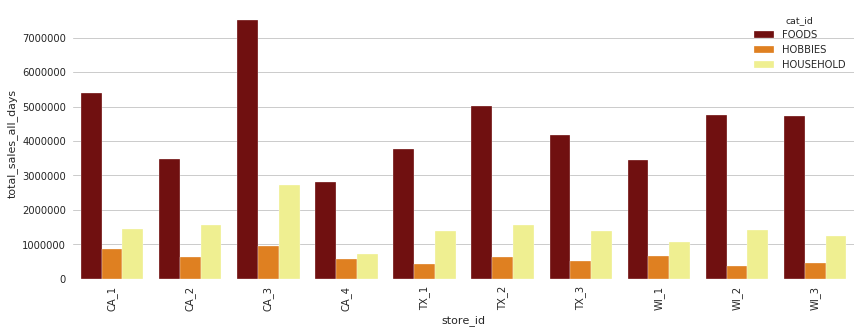

In [41]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, ax1 = plt.subplots(figsize=(14,5))

sns.barplot(x = 'store_id', y='total_sales_all_days', hue='cat_id', data=df3, 
            palette='afmhot', ax=ax1)

plt.xticks(rotation=90)
plt.show()

Same results across all stores

In [42]:
df = df_sales_train.groupby(['state_id', 'cat_id'])['id'].count().reset_index(name='num_sales_by_category')
fig = px.bar(df, x="state_id", y="num_sales_by_category", 
             color="cat_id", title="Distribution of Product_ids Count Across Categories & Each Locale")
fig.show()

A couple of points that could be drawn from this observation are:
- Most items have been sold in california
- Texas and Wisconsin stores have almost total sales i.e. during the same timeframe of 1913 days, same number of items had been sold in both Texas and Wisconsin. Would this observation hold true in the df_sell_prices (revenue dataset) ? Does the observation remain same across different store locations in both Texas and Wisonconsin?

#### Distribution of Items Across Department & Store_ids?

In [43]:
df = df_sales_train.groupby(['dept_id', 'store_id', 'state_id', 'cat_id'])[df_sales_train.columns[6:]].sum().reset_index()
df = df.sort_values('total_sales_all_days', ascending=False)

In [44]:
x_dept = df['dept_id']
x_store = df['store_id']

def items_sold_per_days(x_spec,title_text, title):
    
    '''
    returns plotly plots with drop down menus for specified parameter made in dataframe earlier
    
    inputs: x_spec (categorical feature on the x_axis), title_text(title on dropdown), 
            title (title of the plot)
            
    returns: plotly plots of categorical feature (x_axis) with dropdowns on specific 
    number of days        
    '''
    
    cols = ['d_1', 'd_50', 'd_300', 'd_500', 'd_700', 'd_900', 'd_1100', 'd_1500', 'd_1700',
        'total_sales_all_days', 'median_sales_all_days']

    buttons1 = [dict(method = "restyle",
                 args = [{'x': [x_spec, 'undefined'],
                          'y': [df[cols[k]], 'undefined'],
                          'visible':[True, False]}], 
                 label = cols[k])   for k in range(0, len(cols))]

    fig = go.Figure()
    fig.add_trace(go.Bar(x=x_spec, y = df['d_1'], name='Dept.Sales on day2',
                     marker_color='Crimson'))

    fig.update_layout(title_text= title_text,
                  title_x= 0.4, width=750, height=450, 
                  margin=dict(t=100, b=20, l=0, r=0),
                  autosize = False,
                  updatemenus=[dict(active=0,
                                    buttons=buttons1,
                                    x=0.08,
                                    y=1.13,
                                    xanchor='left',
                                    yanchor='top')
                              ]); 

    fig.add_annotation( x=0.00,  y=1.13, showarrow=False, xref='paper', yref='paper', xanchor='left',
                   text="With<br>"+str(title));
    fig.show()

items_sold_per_days(df['store_id'], 'Distribution of Sales Made on Each Store', 'Stores')
items_sold_per_days(df['state_id'], "Distribution of Sales Made In Each State", 'States')

The data_analysis on these points helps make it clear that:
- Regarding the distribution of sales across department ids, most sales have been made across "FOODS_3" category followed by most sales made across household_1 category
- Stores locale identity along with embedded state_ids  make it clear that the distribution of sales across Texas & Wisconsin stores are NOT the same , though the total number represented across categories (foods, houshold and hobbies) might have come the same.
- The outperformers in each state of CA, TX and Wisonsin are the stores with ids CA_3, TX_2 and WI_3, respectively.

#### Specific item outselling the most?

- Since the df_train_sales contains the information about each specific item and the number of sales made, we can make a few observations regarding the most frequently purchased item too.

- We could plot its behavior across the number of days to get a general gist of its sales pattern across given days. i.e d_1 to d_1913

In [45]:
df_sales_train.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)

id
FOODS_3_090_CA_3_validation        250502
FOODS_3_586_TX_2_validation        192835
FOODS_3_586_TX_3_validation        150122
FOODS_3_586_CA_3_validation        134386
FOODS_3_090_CA_1_validation        127203
                                    ...  
FOODS_2_071_TX_3_validation            16
FOODS_2_057_WI_2_validation            16
HOBBIES_1_170_WI_3_validation          13
FOODS_3_778_CA_2_validation            12
HOUSEHOLD_1_020_CA_3_validation        10
Name: total_sales_all_days, Length: 30490, dtype: int64

Once the total number of sales have been grouped against specific item id i.e. 'id' parameter, it is clear that the item "**FOODS_3_090_CA_3_validation**" has clearly sold most units than any other item in the category followed by **"FOODS_3_586_TX_2_validation"**. i.e. the first item belongs to food_3 category and sold in the CA_3 store location. Similarly, the second one belongs to TX_2 store location (i.e. second store in Texas) also belonging to the same category of FOODS_3 which is also consistent with observations made before.

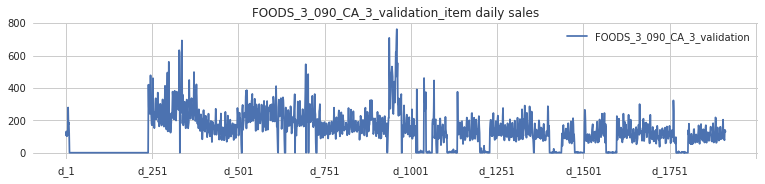

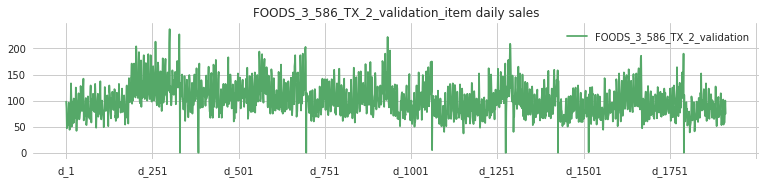

In [46]:
sns.set_style('whitegrid')

def plot_dailysales(spec_id):
    """
    plots the behavior of dailysales of specific ids i.e. spec_id
    
    input: spec_id
    returns : number of sales plotted across number of days 
    """
    df_sales_train.loc[df_sales_train['id'] == spec_id ].set_index('id')[d_cols]\
                .T\
                .plot(figsize = (13,2.5),
                      title =  str(spec_id)+"_item daily sales", 
                      color = next(color_cycle) )
    plt.legend()
    plt.show()

plot_dailysales('FOODS_3_090_CA_3_validation') 
plot_dailysales('FOODS_3_586_TX_2_validation')

#### Item ID outselling most in each category?

In [47]:
df_agg = pd.DataFrame(df_sales_train.groupby(['id', 'cat_id', 'store_id'])['total_sales_all_days'].sum().sort_values(ascending=False))
df_agg = df_agg.reset_index()
df_agg.head(3)

id cat_id store_id  total_sales_all_days
0  FOODS_3_090_CA_3_validation  FOODS     CA_3                250502
1  FOODS_3_586_TX_2_validation  FOODS     TX_2                192835
2  FOODS_3_586_TX_3_validation  FOODS     TX_3                150122

Now that the dataset has been arranged in descending order of total sales, it would be a lot easier to estimate the item_id ('id') outselling others in each category.

In [48]:
print("The 3 item_ids outselling most in FOODS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'FOODS']['id'][:3])))
print("The 3 item_ids outselling most in HOUSEHOLDS category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOUSEHOLD']['id'][:3])))
print("The 3 item_ids outselling most in HOBBIES category are: {}".format(list(df_agg.loc[df_agg['cat_id'] == 'HOBBIES']['id'][:3])))

The 3 item_ids outselling most in FOODS category are: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']
The 3 item_ids outselling most in HOUSEHOLDS category are: ['HOUSEHOLD_1_118_CA_3_validation', 'HOUSEHOLD_1_459_CA_3_validation', 'HOUSEHOLD_1_334_CA_3_validation']
The 3 item_ids outselling most in HOBBIES category are: ['HOBBIES_1_234_CA_3_validation', 'HOBBIES_1_348_CA_1_validation', 'HOBBIES_1_371_CA_1_validation']


In [49]:
df = pd.DataFrame({"days": list(df_sales_train[df_sales_train['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].columns),
                   "sales_data": list(df_sales_train[df_sales_train['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].values.flatten())})

In [50]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

def plot_sample_sales(spec_id, sm_start, sm_end, samples_pick=50):
    """
    plots sample sales data with selection point and ending point specified, along with
    samples_pick point that specifies the samples picked after specified intervals
    
    input: spec_id (item_id or id), sm_start (sample_start), sm_end(sample_end),
    samples_pick (samples picked after how many intervals)
    
    returns: outputs a graph of sample points plotted against daily sales data d_1 to d_1913
    """
    fig, ax1 = plt.subplots(figsize=(13, 2.5))
    
    x1 = list(df_sales_train[df_sales_train['id'] == spec_id][d_cols]\
              .columns)[sm_start:sm_end]
    y1 = list(df_sales_train[df_sales_train['id'] == spec_id][d_cols]\
              .values.flatten())[sm_start:sm_end]
    
    #this conversion for regplot only
    x1 = [x.replace("d_", "") for x in x1]
    x1 = [int(x) for x in x1]
    
    #sns.lineplot(x=x1, y=y1, ax=ax1)
    sns.regplot(x=x1, y=y1, order=10, ax=ax1)
    ax1.set_ylabel("Number of Sales")
    ax1.set_xlabel("Days")

    ax1.set_xticks(x1[::samples_pick])
    ax1.set_xticklabels(x1[::samples_pick], rotation=0)

    fig.tight_layout()
    plt.show()

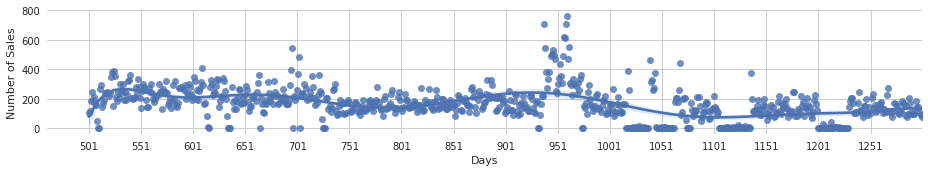

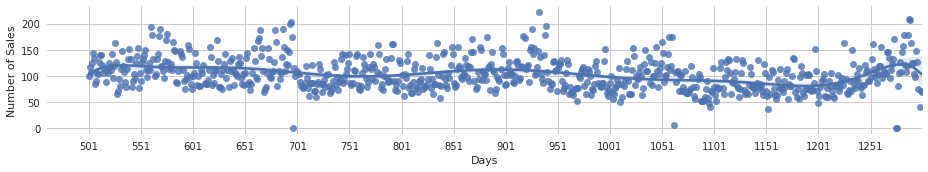

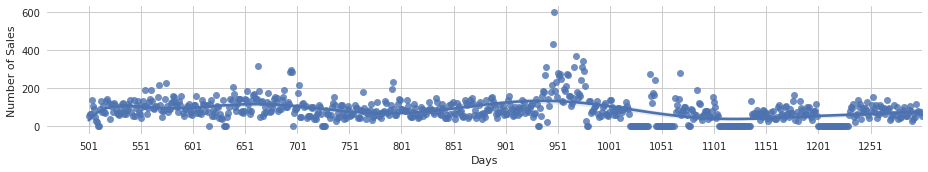

In [51]:
plot_sample_sales('FOODS_3_090_CA_3_validation', 500, 1300)
plot_sample_sales('FOODS_3_586_TX_2_validation', 500, 1300)
plot_sample_sales('FOODS_3_090_CA_1_validation', 500, 1300)

Looking at the above graphs, our regression model does a fairly good job of fitting the line on the sales trend observed between the days 500th to 900th, for the item ids 'FOODS_3_090_CA_3_validation' and 'FOODS_3_586_TX_2_validation'. The graph also points out to the similar trends of troughs and crests between the specific days pointing out towards the occurence of special occasions and events that are driving sales. (To do _explain on order of polynomial and take more cases of ids across foods, household categories across different stores)

### Questions on Sales Revenue?

- First of all, we'd be interested in finding out the specific revenue with respect to each product? But since we have not been provided the dataset with ids (product_ids) in df_sell_prices(revenue dataframe) and there is a mismatch in dataset entries between the both datasets (df_train_sales with almost 30000 rows and df_sell_prices with almost 6M entries), therefore, atbest, a rough estimate could be made by merging both datasets.

- Fortunately, Revenue Dataframe (df_sell_prices) has the categorical level data available, so we could make an estimation regarding the items sold in each category to see what is the specific price where most items are getting sold. 

- We'll first try fitting the non-parametric method of probability distribution since we suspect the data distribution might not be exact replica of a distribution we have seen before, and may include peaks or outliers.

- If the behavior of data distribution does not resemble a known distribution, further investigation would be made to remove the specific data outliers.

In [52]:
df_sell_prices.head(3)

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325    9.578125
1     CA_1  HOBBIES_1_001     11326    9.578125
2     CA_1  HOBBIES_1_001     11327    8.257812

In [53]:
# making a new column category out of the item_id 
df_sell_prices['category'] = df_sell_prices['item_id'].str.split("_", expand=True)[0]

#### Distribution of price among categories?

No handles with labels found to put in legend.


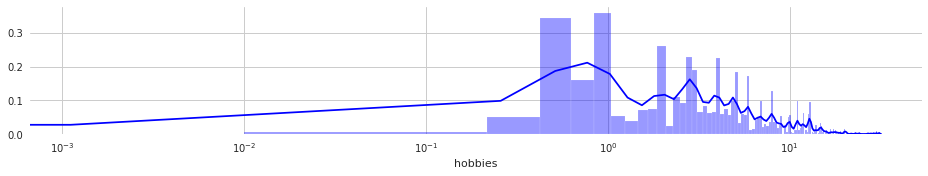

No handles with labels found to put in legend.


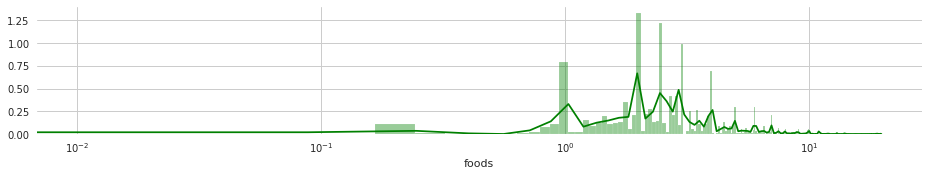

No handles with labels found to put in legend.


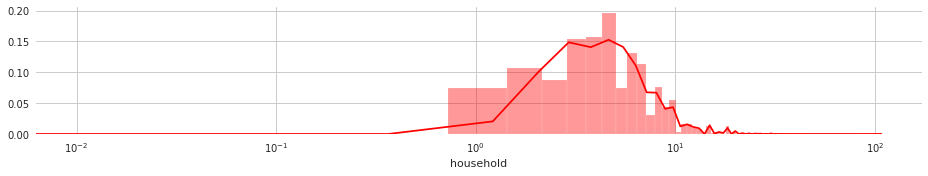

In [54]:
sns.set_style('whitegrid')
#plt.figure(figsize=(15,5))

def kde_plotting(df, category, bin_size, color, label):
    
    '''
    plots the kde density plot of the continuous features of df specified
    
    inputs: df, category(whether, foods, household or hobbies), bin_size(bin size for histogram)
            color (color of the plot), label (label to the plot)
    returns: kde plots with logarithmic scale taken on x_axis
            
    '''
    fig, ax1 = plt.subplots(figsize=(13, 2.5) )

    sns.distplot(df[df['category'] == category]['sell_price'], 
               axlabel = label ,bins=bin_size, color = color, ax=ax1) 

    fig.tight_layout()
    ax1.set_xscale('log')
    plt.legend()
    plt.show()
    
kde_plotting(df_sell_prices, 'HOBBIES', 150, 'b', 'hobbies')   
kde_plotting(df_sell_prices, 'FOODS', 250, 'g', 'foods') 
kde_plotting(df_sell_prices, 'HOUSEHOLD', 150, 'r', 'household') 

# Insights from these kde plots. 

- The probability distribution plot of the **household** items follows an almost normal distribution with a mean centered around a price of 5 Dollars and most items being sold within the 1 to 10 dollars range. This would indicate that most household items that are getting sold lie within the price bracket of 25 cents to 10 dollars
- **Foods** items prices is a multimodal distribution indicating frequent variation in interest among food items purchased. The values occur both towards the relative higher price bracket as well as lower price bracket indicating that the degree of interest of consumers in food items is not only varied but that the Walmart stores have a catalogue of food items that are peaking consumer's interest across different categories. The price bracket in this case also happens to lie within 2 cents to 10 dollars with only very few items getting sold past that range
- The probability distribution of **hobbies** related items prices indicates a mix of bimodal and multimodal distributions. This indicates that while a few items in specific category were sold more than others (first peak that lies in the area between 0.01 dollar to 1 dollar) there are also items towards a relative higher price bracket that have been also sold quite frequently enought to give it a multimodal distribution with small decreasing peaks indicative of decreasing interest in hobbies related items that are relatively expensive but sill significant enough to generate consumer interest. 

# Removing outliers to observe price distribution? 
#### **Quartile Method**

In [55]:
def remove_outliers(df):
    
    '''
    removes the outliers in continous features using quartile ranges
    
    inputs: df(df specified with continous features along side categorical features)
    returns: df with removed outliers
    '''
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    
    return df_final

df = df_sell_prices[['category', 'sell_price']]
df = remove_outliers(df)

/home/explore-student/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



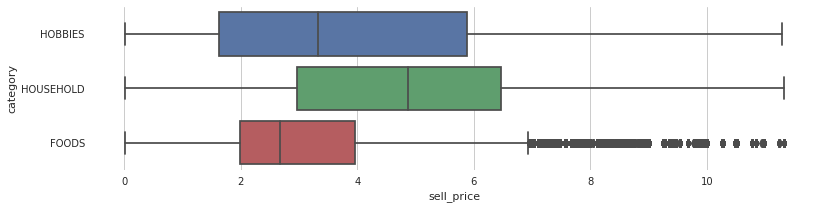

In [56]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.boxplot(y=df['category'], x=df['sell_price'])
plt.show()

After removing most of the outliers, it is apparent that for 
- FOODS related items, 75 % of the items sold are those that are less than 4 dollars
- HOBBIES related items, 75 % of the items sold were less than 6 dollars with an mean price centered around 3.25-3.5 dollars
- HOUSEHOLD items, 75 % of the items sold were less than 6.5 dollars. 

It also represents that there are quite a few outliers in our price data. Since we had observed before using the kdeplots, that the distributions of the dataset were mostly skewed, we used the quartile method of removing the outliers. 


# Distribution of sales on weekdays & special occasions?

Our third dataset named, df_calendar, provides valuable information along the timeseries for the dataset of product_id. This dataset also contains information about special occasions, SNAP (Supplementary Nutrition Assistance Programme) in the USA and coupled with the product_id dataset i.e. df_train_sales would be helpful in observing sales along weekdays, specific dates and special occasions.

In [57]:
df_calendar.head(3)

date  wm_yr_wk   weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101    Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101    Monday     3      1  2011  d_3          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0

In [58]:
df_calendar.groupby(['event_name_1', 'event_type_1'])['wday'].count()

event_name_1         event_type_1
Chanukah End         Religious       5
Christmas            National        5
Cinco De Mayo        Cultural        5
ColumbusDay          National        5
Easter               Cultural        5
Eid al-Fitr          Religious       5
EidAlAdha            Religious       5
Father's day         Cultural        4
Halloween            Cultural        5
IndependenceDay      National        5
LaborDay             National        5
LentStart            Religious       6
LentWeek2            Religious       6
MartinLutherKingDay  National        5
MemorialDay          National        6
Mother's day         Cultural        6
NBAFinalsEnd         Sporting        6
NBAFinalsStart       Sporting        6
NewYear              National        5
OrthodoxChristmas    Religious       5
OrthodoxEaster       Religious       5
Pesach End           Religious       6
PresidentsDay        National        6
Purim End            Religious       6
Ramadan starts       Religious

Looking at the distribution of data in 'event_name_1' and 'event_type_1' it is clear the data here relates to holidays which could reveal important trends when coupled with the information of sales made on the specific event.

In [59]:
df_calendar.groupby(['event_name_2', 'event_type_2'])['wday'].count()

event_name_2    event_type_2
Cinco De Mayo   Cultural        1
Easter          Cultural        1
Father's day    Cultural        2
OrthodoxEaster  Religious       1
Name: wday, dtype: int64

It seems a few entries that have not been made to the 'event_name_1' attribute have been made available in a different category

In [60]:
#Creating and including a new entry of days as well as merging the events_1 and event_2 into
# a single new events_names and types category

df_calendar['days'] = [d.split('-')[2] for d in df_calendar['date']]
df_calendar['events_names'] = pd.concat([df_calendar['event_name_1'], df_calendar['event_name_2']], 
                                        ignore_index=True)
df_calendar['events_types'] = pd.concat([df_calendar['event_type_1'], df_calendar['event_type_2']], 
                                        ignore_index=True)
#calendar_df.drop(['event_name_1', 'event_name_2', 'event_type_1', 'event_type_2'], axis=1, inplace=True)

### What are **SNAP_CA, SNAP_TX, SNAP_WI**?

SNAP stands for "Supplementary Nutrition Assistance Program" that is a federal level program aimed at providing food essentials to low-income households. This program is geared towards providing the food essentials and within the current dataset, the catagories of household items and hobbies items do not fall within the requirements of this program.

This program is only geared towards fighting the food hunger in america and only food related items can be purchased under this program.

In [61]:
df = df_calendar.groupby(['events_types'])['snap_CA'].value_counts().reset_index(name='counts')

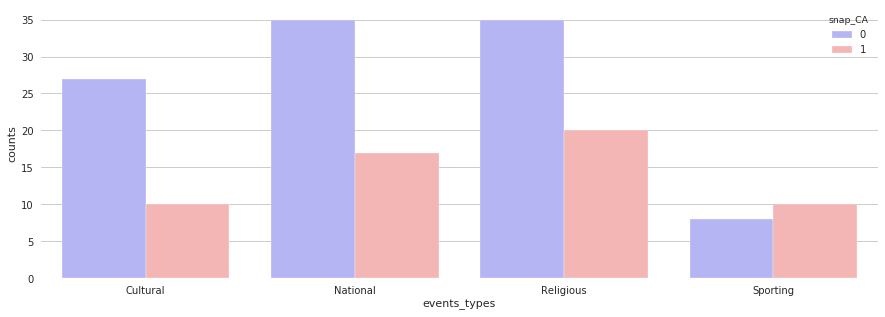

In [62]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(15,5))
sns.barplot(x = 'events_types', y='counts', hue='snap_CA', data=df, palette='bwr')
plt.show()

In [63]:
df = df_calendar.groupby(['events_names'])['snap_CA'].value_counts().reset_index(name='counts')

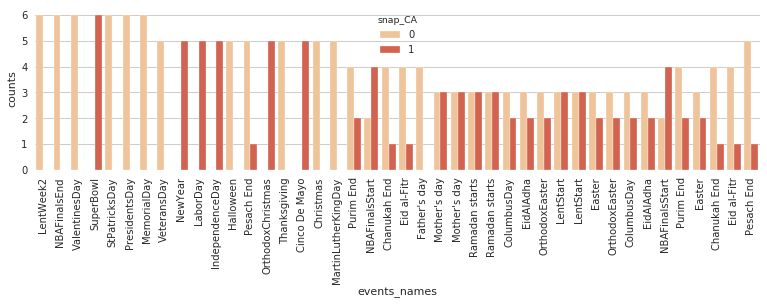

In [64]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
plt.figure(figsize=(13,3))
sns.barplot(x = 'events_names', y='counts', hue='snap_CA', data=df, 
            order = df.sort_values(['counts'], ascending=False).events_names, 
            palette='OrRd')
plt.xticks(rotation=90)
plt.show()

A look at both of these plots indicates the special occasions when the SNAP programme in CA were availed.  

### Distribution of sales items vs sales revenue? 
Now that we have product_id df as well as revenue_df, we'll merge the dataset now to start exploring trends of item_specific_data and sale_price_specific data 

In [65]:
#product id df (df_sales_train) vs revenue_df(df_sell_prices)
df_train_sales_prices = df_sales_train.merge(df_sell_prices, how='inner', left_index=True, right_index=True)  
                                             

In [66]:
df = df_train_sales_prices.groupby(['cat_id', 'state_id', 'store_id_x'])['sell_price'].sum().reset_index(name='total_revenue')
df = df.sort_values(by='total_revenue', ascending=False)

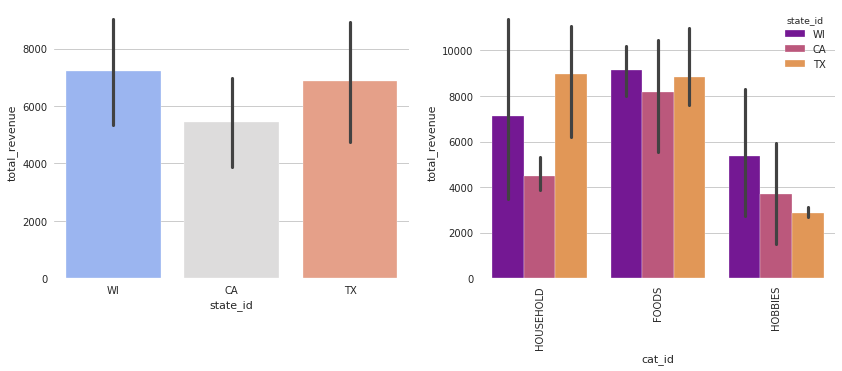

In [67]:
sns.set_style('whitegrid')
sns.axes_style(style='ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.barplot(x = 'state_id', y='total_revenue', data=df, 
            palette='coolwarm', ax=ax1)
sns.barplot(x = 'cat_id', y='total_revenue', hue='state_id', data=df, 
            palette='plasma', ax=ax2)

plt.xticks(rotation=90)
plt.show()

Despite the fact that sales prices data contains almost 6M entries, in the present case, we are only considering common entries between revenue df and product_ids df. A few significant insights have come forward, i.e. 

- Although we saw that California consistently was the one state where the unique product_id most sales were made, the most revenue collected came from the Wisconsin State stores.
- Similarly, within the distribution of categories, WI and TX contrinute more sales revenue than the CA stores. 
- Wisconsin leads the revenue in FOODS and HOBBIES, while Texas leads the revenue in HOUSEHOLD.
- CA tends to contribute the smallest revenue out of all three states, despite having the most sales of items in its stores locations.

In [68]:
df_train_sales_cal = df_sales_train.set_index('id')[d_cols].T.merge(df_calendar.set_index('d'), 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')


### *Behaviour on TimeSeries & Analysis?*

Timeseries questions would involve merging the datasets of product_ids and data information to enable a thorough analysis through time. We could find out information on the sales of items alongside the timeseries and also find out what specific occations, the weekends and specials occasions might have had on number of units sold.

**Rolling Averages** : Rolling averages are a useful tool to employ to understand the long term effects in a timeseries represented data. The rationale behind using rolling averages is the fact that resulting reading coming out of rolling averages smoothes out the data against daily fluctuations, and could help data professionals understand the long term impact of the sales/inventory across time. Therefore, we are going to use both rolling average as a necassary tool.

#### Distribution of Total Sales Against Product_id on TimeSeries?

In [69]:
#Changing the date type to datetime so that it is depicted as so:

df_calendar.date = pd.to_datetime(df_calendar.date)
type(df_calendar.date)

pandas.core.series.Series

In [70]:
train_sales_cal_df = df_sales_train.set_index('id')[d_cols].T.merge(df_calendar.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum(axis=1)

In [71]:
train_sales_cal_df = train_sales_cal_df[['total_sales']]
train_sales_cal_df = train_sales_cal_df.reset_index()

In [72]:
fig = px.line(train_sales_cal_df, x='date', y="total_sales", 
             template = 'plotly_white', title = 'Total Sales by Product id', 
             width=800, height=450)

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all")
            ]) 
                      ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

From this graph it is difficult to tell the trend and seasonality patterns within our dataset. Althogh there is an increasing trend, the number of values for the entire dataset represented in the graph make it difficult to ascertain the true picture.

Fortunately, using the seasonal_decompose module in statsmodel, we could find out the seasonality and trend patterns in the timeseries. We are going to choose the "mulitplicative seasonality" owing to the fact of variability in the magnitude of the number of sales along the timeseries.

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):

    '''
    returns decomposed time series components (with seasonality, trend and residuals ) of time_series df
    
    inputs: df(time series df), model_specified (whether additive or multiplicative ), period(number of days)
    returns: trend values, seasonality values and residual values of time_series df
    
    '''
    df_decomposition = seasonal_decompose(
                               x=df.set_index(['date']), 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    return est_trend, est_seasonal, est_residual

sample_time_s1 = train_sales_cal_df[400:700]
est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 
                                                              'multiplicative', 30)

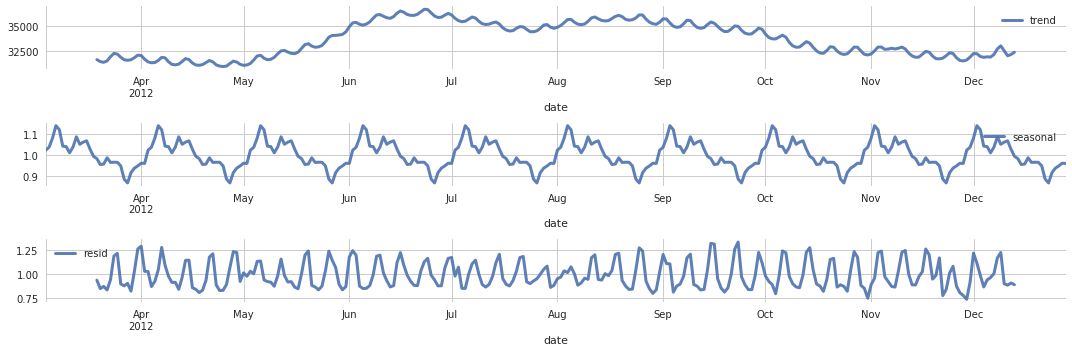

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 7))

est_trend.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax1)
est_seasonal.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax2)
est_residual.plot(figsize=(15, 5) ,
                 alpha=0.9, 
                 lw=3, ax = ax3)

fig.tight_layout()
plt.show()

After looking at the trend, the seasonality and residuals patterns, we have the following insights:

* There is definitely seasonality in our dataset, and in order to observe its pattern, we have taken a subset of dataset.
* Since the seasonal and residual components are changing the trend line by an amount that is 'Dependent" of the changes in seasonal and residual components, we have a multiplicative behaviour.

In [75]:
train_sales_cal_df = train_sales_cal_df.set_index('date')

In [76]:
def time_and_rolling_plot(df, title_text, rolling_days=30, height=2.2):

    '''
    plots the time_series of dailysales made along with rolling mean plot
    
    inputs: df, title_text(plot title), rolling_days (rolling mean to be taken across), 
            height(height of the plot to be specified)
            
    returns: time series plot and rolling mean plot of the variable specified 
    '''
    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(13, height))
    df.plot(figsize=(13, height),
                        alpha=0.8,
                        title="Time Plot for the " + str(title_text), 
                        lw=2, color=next(color_cycle), ax=ax1)
    df.rolling(rolling_days).mean().plot(figsize=(13, height),
                                          alpha=1, 
                                          legend="Rolling Mean on 30 days", 
                                          lw=2.5, color=next(color_cycle), ax=ax1)
    ax1.legend(['Total Sales Per Category', 'total_sales_rolling_mean'])
    plt.show()

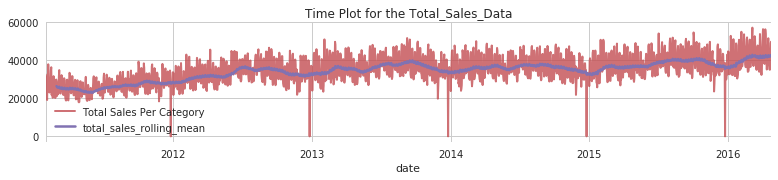

In [77]:
time_and_rolling_plot(train_sales_cal_df, 'Total_Sales_Data')

Looking at the graph, it is obvious that the unit sales across timeline have been on a steady increase. This would imply that: 

* There are items remaining in inventory must be tracked.
* We could plot a sales of a few items to see how the behavior of each one fares across timeline. 

In [78]:
#finding the product_ids of 25 most sold units
train_sales_most_sold_25 = df_sales_train.groupby(['id'])['total_sales_all_days'].sum().sort_values(ascending=False)[:25]
train_sales_most_sold_25 = train_sales_most_sold_25.reset_index(name='total_sales')
train_sales_most_sold_25.iloc[0:5]

id  total_sales
0  FOODS_3_090_CA_3_validation       250502
1  FOODS_3_586_TX_2_validation       192835
2  FOODS_3_586_TX_3_validation       150122
3  FOODS_3_586_CA_3_validation       134386
4  FOODS_3_090_CA_1_validation       127203

In [79]:
train_sales_most_sold_25['state'] = train_sales_most_sold_25['id'].str.split("_", expand=True)[3]
train_sales_most_sold_25.groupby(['state'])['total_sales'].sum().sort_values(ascending=False)

state
TX    1233196
CA    1005717
WI     470367
Name: total_sales, dtype: int64

So, out of the most popular categories of 25 most sold items, more items had been sold in Texas than in either California or Wisconsin.

In [80]:
train_sales_cal_df = df_sales_train.set_index('id')[d_cols].T.merge(df_calendar.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

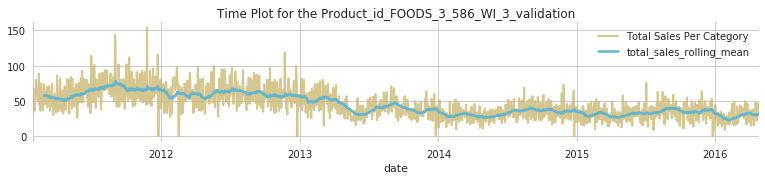

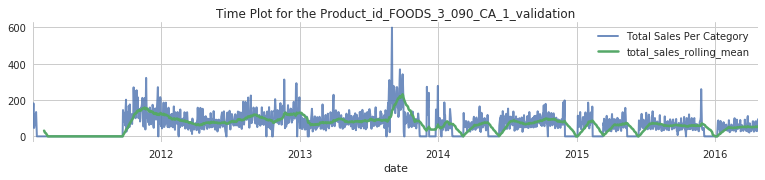

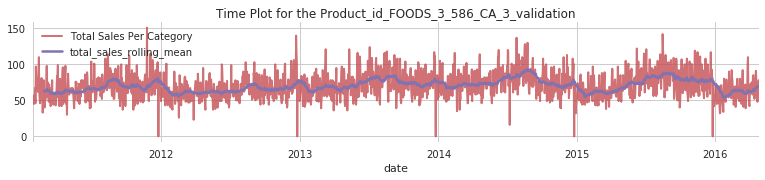

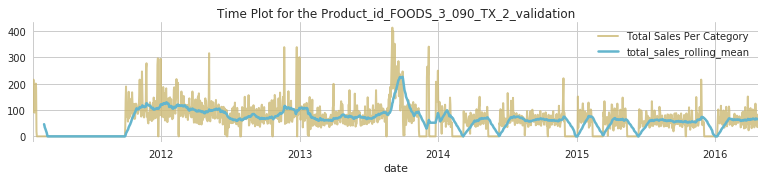

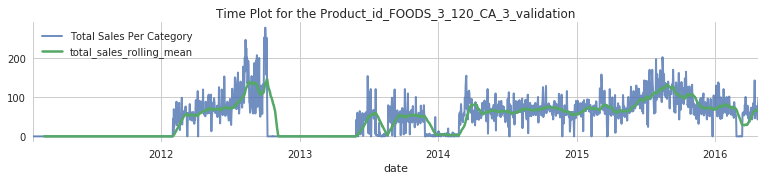

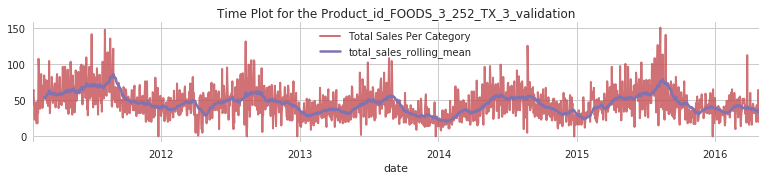

In [81]:
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_WI_3_validation']], "Product_id_FOODS_3_586_WI_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_CA_1_validation']], "Product_id_FOODS_3_090_CA_1_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_586_CA_3_validation']], "Product_id_FOODS_3_586_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_090_TX_2_validation']], "Product_id_FOODS_3_090_TX_2_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_120_CA_3_validation']], "Product_id_FOODS_3_120_CA_3_validation")
time_and_rolling_plot(train_sales_cal_df[['FOODS_3_252_TX_3_validation']], "Product_id_FOODS_3_252_TX_3_validation")

### Distribution of total sales against each category?

In [82]:
train_sales_cal_df = df_sales_train.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(df_calendar.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [83]:
train_sales_cal_df.head(5)

FOODS  HOBBIES  HOUSEHOLD
date                                   
2011-01-29  23178.0   3764.0     5689.0
2011-01-30  22758.0   3357.0     5634.0
2011-01-31  17174.0   2682.0     3927.0
2011-02-01  18878.0   2669.0     3865.0
2011-02-02  14603.0   1814.0     2729.0

In [84]:
def plotly_time_plot_markers(df, text, samples_onwards=1000):

    '''
    plots time_series plotly scatter plot of the format specified in df 
    
    inputs: df(dataframe), text(title text ), samples_onwards (time_series_sample and the end)
    returns : plotly time series scatter plot
    
    '''
    fig = go.Figure()
    for c in df.columns[:4]:
        fig.add_traces(go.Scatter(x=train_sales_cal_df[samples_onwards:].index, 
                              y=train_sales_cal_df[samples_onwards:][c],
                              mode='markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()    

plotly_time_plot_markers(train_sales_cal_df, 'Category')  

The results of the plot indicate that:

- There is defintely an increase in the number of items being sold with time.
- The items sold in the Food and Household category have seen a more gradual increase than those of hobbies related items.

### Distribution of total sales sold per state?

In [85]:
train_sales_cal_df = df_sales_train.groupby(['state_id'])[d_cols].sum().T.merge(df_calendar.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [86]:
#train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df

CA       TX       WI
date                                 
2011-01-29  14195.0   9438.0   8998.0
2011-01-30  13805.0   9630.0   8314.0
2011-01-31  10108.0   6778.0   6897.0
2011-02-01  11047.0   7381.0   6984.0
2011-02-02   9925.0   5912.0   3309.0
...             ...      ...      ...
2016-04-20  15148.0   9600.0  10595.0
2016-04-21  14488.0   9602.0  10943.0
2016-04-22  17095.0  10615.0  12807.0
2016-04-23  21834.0  12266.0  14862.0
2016-04-24  23187.0  12282.0  14326.0

[1913 rows x 3 columns]

In [87]:
from plotly.subplots import make_subplots

def plotly_time_plot_rolling(df, text, start_col=0, end_col=3, rolling_days=30):

    '''
    time series rolling plots of the categories specified in df
    inputs: df (dataframe with ts as index, and columns as categories), text (title of the plot)
            rolling_days (number of rolling days)
    
    returns: plotly time series plot of sales along the categories specified as columns in df
    '''
    fig = go.Figure()
    for c in df.columns[start_col:end_col]:
        fig.add_traces(go.Scatter(x=df.rolling(rolling_days).mean().index, 
                              y=df.rolling(rolling_days).mean()[c],
                              mode='lines+markers',
                              name = c))

    fig.update_layout( title = 'Sales per Day by ' + str(text), template = 'plotly_white',
        width=750, height=550,
        xaxis_tickformatstops = [
            dict(dtickrange=["M1", "M12"], value="%b '%y"),
        ]
    )
    
    fig.update_layout(
    xaxis=dict(
    rangeselector=dict( buttons=list([ dict(count=1, label="1m", step="month", stepmode="backward"),
    dict(count=6,label="6m", step="month", stepmode="backward"),
    dict(count=1, label="YTD", step="year", stepmode="todate"),
    dict(count=1, label="1y", step="year", stepmode="backward"),
    dict(step="all") ])  ),
        rangeslider=dict(
            visible=True
        ),
        type="date" ) )

    fig.update_xaxes(rangeslider_visible=True)    
    fig.show()   

plotly_time_plot_rolling(train_sales_cal_df, 'State')

While there has been an increase in the number of sales across all three states (i.e. CA, TX, and WI). It is interesting to note  that:

* There is an overall increase in the sales of items across all states.
* WI sales cross TX sales at around Oct'14 and Sept'15 indicating that that could be boost in the sales of category of items that are seasonal. We'll try and investigate the sales of categories across separate states to further shed a light on this.

In [88]:
#referring to the solution provided at https://stackoverflow.com/questions/43223615/join-dataframes-one-with-multiindex-columns-and-the-other-without

train_sales_cal_df = df_sales_train.groupby(['state_id', 'cat_id'])[d_cols].sum().T\
              .join(pd.concat([df_calendar.set_index('d')['date']], axis=1, keys=['dates']))
train_sales_cal_df.head(7)

/home/explore-student/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



(CA, FOODS)  (CA, HOBBIES)  (CA, HOUSEHOLD)  (TX, FOODS)  (TX, HOBBIES)  \
d_1      10101.0         1802.0           2292.0       6853.0          879.0   
d_2       9862.0         1561.0           2382.0       7030.0          870.0   
d_3       6944.0         1472.0           1692.0       5124.0          526.0   
d_4       7864.0         1405.0           1778.0       5470.0          809.0   
d_5       7178.0         1181.0           1566.0       4602.0          501.0   
d_6       8256.0         1459.0           1607.0       7067.0          831.0   
d_7       9005.0         1314.0           1932.0       4671.0          390.0   

     (TX, HOUSEHOLD)  (WI, FOODS)  (WI, HOBBIES)  (WI, HOUSEHOLD)      dates  
d_1           1706.0       6224.0         1083.0           1691.0 2011-01-29  
d_2           1730.0       5866.0          926.0           1522.0 2011-01-30  
d_3           1128.0       5106.0          684.0           1107.0 2011-01-31  
d_4           1102.0       5544.0          455.0            985.0 2011-02-01  
d_5            809.0       2823.0          132.0            354.0 2011-02-02  
d_6           1108.0       6770.0          930.0           1183.0 2011-02-03  
d_7           1165.0       6814.0         1240.0           1479.0 2011-02-04

In [89]:
select_cols_ca = [c for c in train_sales_cal_df.columns if 'CA' in c]
select_cols_tx = [c for c in train_sales_cal_df.columns if 'TX' in c]
select_cols_wi = [c for c in train_sales_cal_df.columns if 'WI' in c]
#train_sales_df['total_sales_all_days'] = train_sales_df[d_cols].sum(axis = 1)
#train_sales_cal_df = 
df_CA = train_sales_cal_df.set_index('dates')[select_cols_ca]
df_TX = train_sales_cal_df.set_index('dates')[select_cols_tx]
df_WI = train_sales_cal_df.set_index('dates')[select_cols_wi]

#df_CA.columns = [col[1] for col in df_CA.columns]
#df_TX.columns = [col[1] for col in df_TX.columns]
#df_WI.columns = [col[1] for col in df_WI.columns]

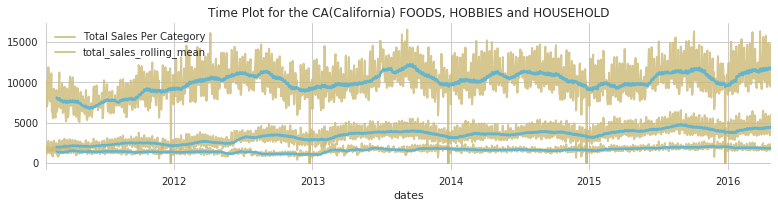

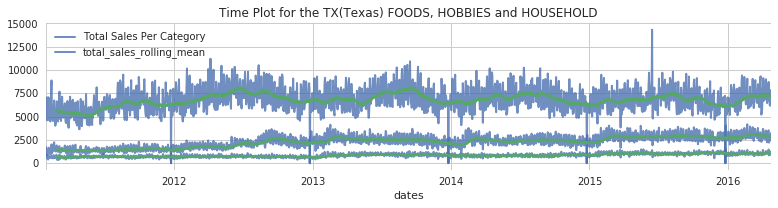

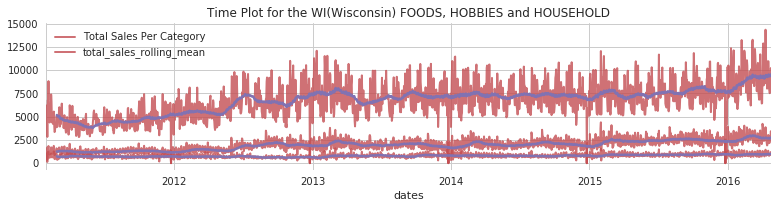

In [90]:
time_and_rolling_plot(df_CA, 'CA(California) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_TX, 'TX(Texas) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
time_and_rolling_plot(df_WI, 'WI(Wisconsin) FOODS, HOBBIES and HOUSEHOLD', height=2.7)
#time_and_rolling_plot(df_CA.iloc[:,1].reset_index(), "CA HOBBIES")
#time_and_rolling_plot(df_CA.iloc[:,2].reset_index(), "CA State")

By looking at the above graphs, some of the trends regarding the food distribution category along separate states have become evident.

- Along the FOODS distribution, both CA and TX see large bumps in sales around June'12 and September'12-October'12 with the next peak coming around in October'13 that is larger than the sales in June'12 with the same trend continuing to repeat itself along other dates in 2014, and 2015.

- However, the sales along WI stores have a slightly different pattern with peaks of sales occuring in July'12 and next largest being observed in Feb-Mar'13. Similarly, the sales pick up around September in 2013.

- In Household items distribution, the peaks of sales across all stores in CA, TX and WI occur around July, March while relatively huge dips in sales occuring in all three locations around the month of Jan-Feb.

- In Hobbies items sales, there is surprising peak in sales (albiet different in actual number of units sold) across similar dates in all store locations (for example Feb'13 and Feb'15) with a slight dip in sale in Aug-Sep'13.

In [91]:
train_sales_cal_df = df_sales_train.set_index('id')[d_cols].T.merge(df_calendar.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')
train_sales_cal_df['total_sales'] = train_sales_cal_df.sum()


In [92]:
item_ids = [c for c in train_sales_cal_df.columns if 'validation' in c]

In [93]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year

In [94]:
df = train_sales_cal_df.groupby(['year', 'month'])[item_ids].sum()
df = df.reset_index()

In [95]:
def find_items_per_specific_date(df, year, month, category, number):
    
    '''
    finds the five most sold product_ids in user specified category, year and month
    
    inputs: df(item_ids along with year and month), year, month, category (household, 
    foods or hobbies), number (how many results to be displayed)
    
    returns : table of product ids with specfied number and date and number of sales made
    '''
    
    df = df.loc[(df['year'] == year) & (df['month'] == month)][item_ids].T.reset_index()
    df.columns = ['item_id', 'sales_count']
    df = df.set_index('item_id')
    item_type = [c for c in df.index if category in c]
    df = df[df.index.isin(item_type)]
    df = df.sort_values(by = ['sales_count'], ascending=False)[:number]
    
    return df

print("Most sold Foods during requested date\n"
      ,find_items_per_specific_date(df, 2012, 7, 'FOODS', 5) )
print("Most sold Household items during requested date\n" 
      ,find_items_per_specific_date(df, 2013, 3, 'HOUSEHOLD', 5) )

Most sold Foods during requested date
                              sales_count
item_id                                 
FOODS_3_090_CA_3_validation         8054
FOODS_3_281_CA_3_validation         3851
FOODS_3_586_TX_2_validation         3458
FOODS_3_120_CA_3_validation         2940
FOODS_3_090_CA_1_validation         2780
Most sold Household items during requested date
                                  sales_count
item_id                                     
HOUSEHOLD_1_334_CA_3_validation         1346
HOUSEHOLD_1_118_CA_3_validation         1253
HOUSEHOLD_1_351_CA_3_validation         1043
HOUSEHOLD_1_277_CA_3_validation         1014
HOUSEHOLD_1_334_TX_1_validation          914


These are the five item ids that have been selling most in California and Texas locations.
* While the first one "FOODS_3_090_CA_3_validation" is the same as the one that was most sold during our earlier analysis, the second observation is quite different to earlier assessment and the item most sold in second place has id "FOODS_3_281_CA_3_validation"
* The items that were contributing to the sales bump of household items are also mentioned above. The household item sold most during the bump period is HOUSEHOLD_1_334_CA_3_validation.

### Distribution of total sales vs store_id?

In [96]:
train_sales_cal_df = df_sales_train.groupby(['store_id'])[d_cols].sum()\
                                                .T.merge(df_calendar.set_index('d')['date'], 
                                                        left_index=True, right_index=True,
                                                        validate="1:1").set_index('date')

In [97]:
train_sales_cal_df.head(7)

CA_1    CA_2    CA_3    CA_4    TX_1    TX_2    TX_3    WI_1  \
date                                                                         
2011-01-29  4337.0  3494.0  4739.0  1625.0  2556.0  3852.0  3030.0  2704.0   
2011-01-30  4155.0  3046.0  4827.0  1777.0  2687.0  3937.0  3006.0  2194.0   
2011-01-31  2816.0  2121.0  3785.0  1386.0  1822.0  2731.0  2225.0  1562.0   
2011-02-01  3051.0  2324.0  4232.0  1440.0  2258.0  2954.0  2169.0  1251.0   
2011-02-02  2630.0  1942.0  3817.0  1536.0  1694.0  2492.0  1726.0     2.0   
2011-02-03  3276.0  2288.0  4369.0  1389.0  2734.0  3439.0  2833.0  2049.0   
2011-02-04  3450.0  2629.0  4703.0  1469.0  1691.0  2588.0  1947.0  2815.0   

              WI_2    WI_3  
date                        
2011-01-29  2256.0  4038.0  
2011-01-30  1922.0  4198.0  
2011-01-31  2018.0  3317.0  
2011-02-01  2522.0  3211.0  
2011-02-02  1175.0  2132.0  
2011-02-03  2244.0  4590.0  
2011-02-04  2232.0  4486.0

In [98]:
#PLOT one by one to avoid memory overload

plotly_time_plot_rolling(train_sales_cal_df, 'Store')
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=4, end_col=7)
plotly_time_plot_rolling(train_sales_cal_df, 'Store', start_col=7, end_col=10)

Looking at the above plot with respect to specific stores, it is indicative that:

* CA_3 store location has the most items sold.
* CA_4 store location has the least items old across the timeline.
* TX_2 has the most items sold across timeline with most items sales peaking around Sep'13.
* All Texas store locations (TX_1, TX_2, TX_3) experience a boost in sales around Feb_Mar'15 , with a peak around August'15 and then bottom out around Dec'15.
* Wisconsin Store locations experience a rather unpredictable pattern.
* Store WI_2 accelerates past the sold of WI_3 in Dec'12 and then continues to maintain the lead.
* Stores WI_2, WI_1 were underperformers in the beginning but experienced a boost in sales July'12 and November'12, respectively.
* There appears to be a continuous decline in the performance of sold items for the store location WI_3 that are only relatively improved towards the end.

### Distribution of Sales Per Specific Days/Weekends?

In [99]:
train_sales_cal_df = df_sales_train.groupby(['cat_id'])[d_cols].sum().\
                                                T.merge(df_calendar.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1").set_index('date')

In [100]:
train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df['date'] = pd.to_datetime(train_sales_cal_df['date'])
train_sales_cal_df['month'] = train_sales_cal_df.date.dt.month
train_sales_cal_df['day'] = train_sales_cal_df.date.dt.day
train_sales_cal_df['year'] = train_sales_cal_df.date.dt.year
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.weekday
train_sales_cal_df['weekday'] = train_sales_cal_df.date.dt.day_name()
train_sales_cal_df.head(7)

date    FOODS  HOBBIES  HOUSEHOLD  month  day  year    weekday
0 2011-01-29  23178.0   3764.0     5689.0      1   29  2011   Saturday
1 2011-01-30  22758.0   3357.0     5634.0      1   30  2011     Sunday
2 2011-01-31  17174.0   2682.0     3927.0      1   31  2011     Monday
3 2011-02-01  18878.0   2669.0     3865.0      2    1  2011    Tuesday
4 2011-02-02  14603.0   1814.0     2729.0      2    2  2011  Wednesday
5 2011-02-03  22093.0   3220.0     3898.0      2    3  2011   Thursday
6 2011-02-04  20490.0   2944.0     4576.0      2    4  2011     Friday

In [101]:
df_food = train_sales_cal_df.groupby(['weekday', 'day'])['FOODS'].sum().reset_index(name='sales')
df_house = train_sales_cal_df.groupby(['weekday', 'day'])['HOUSEHOLD'].sum().reset_index(name='sales')
df_hobb = train_sales_cal_df.groupby(['weekday', 'day'])['HOBBIES'].sum().reset_index(name='sales')


In [102]:
def heatmap_plot_dates(df, title_text):

    '''
    returns the heatmap based plot for the df with time_series data in it
    
    inputs : df (dataframe with time based elements, such as weekdays, months etc.)
             title_text (text of the plot to be shown)
    returns : Heatmaps of Weekdays along number of days of a months
    '''
    fig = make_subplots(rows=1, cols=1, vertical_spacing = 0.15, 
                    subplot_titles=title_text,
                    shared_yaxes = True
                   )
    fig.add_trace( go.Heatmap(
                   z=[[df.loc[(df['day'] == day) & (df['weekday'] == weekday)]['sales'].sum()
                     for day in range(1, 31+1)] for weekday in df.weekday.unique()],
                   x=list(df.day.unique()),
                   y=list(df.weekday.unique()),
                   hoverongaps = False, 
                   colorbar = dict(title= title_text + '_Sales', 
                                   thickness=15)), row=1, col=1)
    fig.update_layout(title = title_text + '_Sale Distribution', height=2 * 20 + 300, width=1 * 700, showlegend=False)
    fig.show()

In [103]:
heatmap_plot_dates(df_food, 'FOODS')
heatmap_plot_dates(df_house, 'HOUSEHOLD')
heatmap_plot_dates(df_hobb, 'HOBBIES')

## *Time Series Forecasting*

In time series forecasting, it is imperitive that the time series is stationary. A series is said to be stationary if its mean and variance remain constant over time. A time series forecasting requires that series be stationary so that any particular forecast will be more accurate if the current particular behavior over time is known. Should it be non-constant, there is high probability that the predictions made at one time would NOT be represented in series over some other time interval. 

Time series forecasting requires very specific criterion i.e.

1. Constant Mean
2. Constant Variance
3. An auto-correlation that does not depend on time

#### Stationary Time Series

Before we could make the time series stationary, we are going to need some form of a method where we could confirm that the time series extracted is indeed stationary. There are a few statistics test as well as we can plot the time series mean and variance as a function of time to observe that the series is indeed stationary. 

One of the time series stationary test is called the Dickey-Fuller Test. This test provides us with a test statistic as well as confidence intervals for the critical values. The objective is to determine whether the test statistic is less than the critical value, if it is we can **reject** the null hypothesis. The assumption of null and alternative hypotheses in this test is as follows:

* Null Hypothesis: The time series has some time component, and has a unit root suggesting a highly dependent time orientation indicating the presence of non-stationarity.
* Alternative Hypothesis: The time series does not have a unit root, indicating that it does NOT have a time dependent structure and consequently the time series is stationary.

In [104]:
train_sales_cal_df = df_sales_train.set_index('id')[d_cols].T.merge(df_calendar.set_index('d')['date'], 
                                                                    left_index=True, right_index=True,
                                                                    validate="1:1")
train_sales_cal_df['avg_sales'] = train_sales_cal_df.mean(axis=1)


/home/explore-student/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



In [105]:
##train_sales_cal_df = train_sales_cal_df[['total_sales']]
##train_sales_cal_df = train_sales_cal_df.reset_index()
##train_sales_cal_df = train_sales_cal_df.set_index('date')

train_sales_cal_df = train_sales_cal_df.reset_index()
train_sales_cal_df.rename(columns={'index': 'daysnum'}, inplace=True)
train_sales_cal_df = train_sales_cal_df.set_index('date').asfreq('d')
train_sales_cal_df.head(2)

daysnum  HOBBIES_1_001_CA_1_validation  \
date                                                
2011-01-29     d_1                              0   
2011-01-30     d_2                              0   

            HOBBIES_1_002_CA_1_validation  HOBBIES_1_003_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   

            HOBBIES_1_004_CA_1_validation  HOBBIES_1_005_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   

            HOBBIES_1_006_CA_1_validation  HOBBIES_1_007_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   

            HOBBIES_1_008_CA_1_validation  HOBBIES_1_009_CA_1_validation  ...  \
date                                                                      ...   
2011-01-29                             12                              2  ...   
2011-01-30                             15                              0  ...   

            FOODS_3_819_WI_3_validation  FOODS_3_820_WI_3_validation  \
date                                                                   
2011-01-29                           14                            1   
2011-01-30                           11                            1   

            FOODS_3_821_WI_3_validation  FOODS_3_822_WI_3_validation  \
date                                                                   
2011-01-29                            0                            4   
2011-01-30                            0                            4   

            FOODS_3_823_WI_3_validation  FOODS_3_824_WI_3_validation  \
date                                                                   
2011-01-29                            0                            0   
2011-01-30                            0                            0   

            FOODS_3_825_WI_3_validation  FOODS_3_826_WI_3_validation  \
date                                                                   
2011-01-29                            0                            0   
2011-01-30                            6                            0   

            FOODS_3_827_WI_3_validation  avg_sales  
date                                                
2011-01-29                            0   1.070220  
2011-01-30                            0   1.041292  

[2 rows x 30492 columns]

In [106]:
train_sales_cal_df.index = pd.to_datetime(train_sales_cal_df.index)
type(train_sales_cal_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [107]:
def time_series_stationary_test(df):
    
    '''
    returns time_series plots along with rolling mean plot, standard_dev calculated plot
    and results of the Dickey_Fuller Test performed on time_series df
    
    inputs: df (time_series based df)
    
    returns : time_series plot, rolling_mean plot, std_plot and Dickey_Fuller Test Statistics
              performed on time_series
    '''
    #df_filter = df.loc[df['id'] == series_ids][d_cols]
    #df_filter = df.loc[df['id'] == series_ids]['sold']
    #df_filter = pd.Series(df_filter.values.flatten())
    
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    
    rolling_mean = df.rolling(window=7).mean()
    rolling_std =  df.rolling(window=7).std()
    
    #plotting the points
    original_series = df.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, color=next(color_cycle), label='original_series', ax=ax1)
    mean_series = rolling_mean.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = 'o', color=next(color_cycle), label='rolling_mean', ax=ax1)
    std_series = rolling_std.plot(figsize=(15, 5), alpha=1, 
                        lw=1.2, marker = '*' , color=next(color_cycle), label='rolling_std', ax=ax1)
    
    ax1.legend(['Original_Series', 'Mean_Series', "Std_Series"])
    plt.show()
    
    #Performing a Dickey-Fuller Test
    print("\n============++++==========\n")
    print("Results of the Dickey_Fuller Test")
    result = adfuller(df, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('No of lags: %f' %result[2])
    print('No of Obs used for ADF Calculation & Critical Values: %f' %result[3])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    #output = pd.Series(result[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
    #for key,value in result[4].items():
    #    output['Critical Value (%s)'%key] = value
    #print (output)

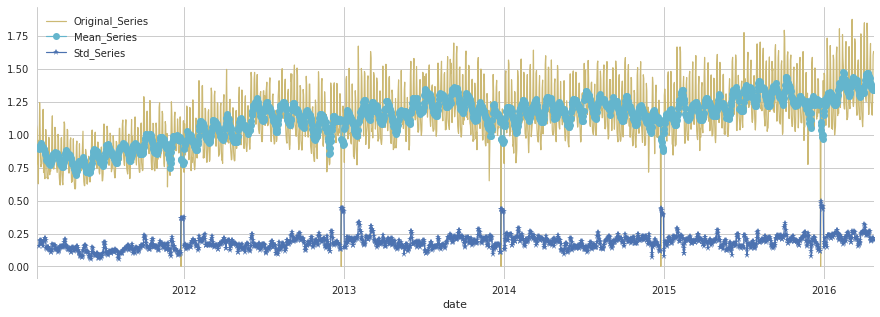


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -1.565373
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1886.000000
p-value: 0.500960
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [108]:
time_series_stationary_test(train_sales_cal_df[['avg_sales']])

A few keypoints from the graph and the Dickey-Fuller tests indicate that:
* Mean series is increasing with time and is not constant so series is not stationary
* Standard deviation series also has quite a few deivations which indicates that the time series is not stationary
* ADF statistic is larger than the critical value which indicates that the series still has a unit root

#### **Methods For Making Time Series Stationary**
Since the time series has both seasonality and trend components, we are going to adopt methods that would remove both trend and seasonality. Methods that we are going to use include:

* **Differencing**
* **Decomposition**

##### **Differencing**

In order to perform this let us first take log , perform a log difference between the time series and its lag and look at the results

In [109]:
df_log_diff = np.log(train_sales_cal_df[['avg_sales']]) - np.log(train_sales_cal_df[['avg_sales']]).shift()
#df['sold'] = df_log_diff
#df['sold'] = df['sold'].dropna()
df_log_diff = df_log_diff.dropna()

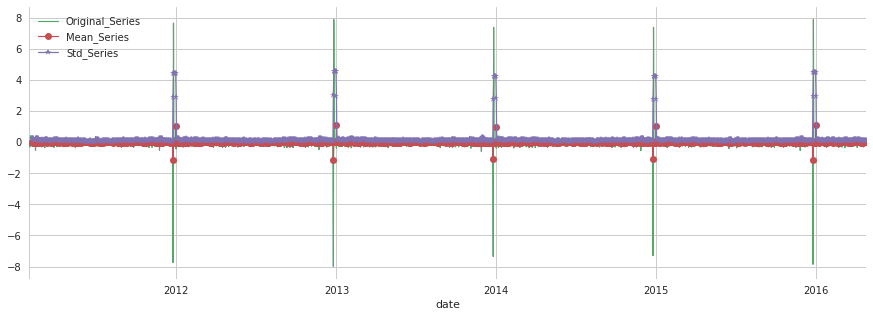


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -16.908187
No of lags: 26.000000
No of Obs used for ADF Calculation & Critical Values: 1885.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [110]:
time_series_stationary_test(df_log_diff)

We can observe that the test statistic value is less than even 1 % of the critical value, which indicates that we can reject the null hypothesis (that series is non-stationary) with 99 % confidence and p_value of 0 indicates that the test result is significant. 

#### **Decomposition**
Decomposition is another way to make the time series stationary. The decomposition of dataset yields three properties for the time series dataset

* Trend - That is whether there is an increase or decrease in total sales over long term
* Seasonality - Whether there are repeating patterns within the dataset
* Residual - What is the contribution of behavior in the time series dataset (total sales ) without trend and seasonality added

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose

def time_series_decompose(df, model_specified, period):
    
    '''
    returns the trend, seasonality, and residual components decomposition of time_Series and
    plots the results 
    
    inputs: df(time_series df along with sales specified), model_specified (whether to use
            additive or multiplicative), period (number of days where seasonality 
            is to be observed)
    returns: decomposition plots along with decomposition components, in trend, seasonality
    and residuals
    '''

    df_decomposition = seasonal_decompose(
                               x=df, 
                               model= model_specified, 
                               period=period)
    
    est_trend = df_decomposition.trend
    est_trend = est_trend.reset_index(name='trend').set_index('date')
    est_seasonal = df_decomposition.seasonal
    est_seasonal = est_seasonal.reset_index(name='seasonal').set_index('date')
    est_residual = df_decomposition.resid
    est_residual = est_residual.reset_index(name='resid').set_index('date')
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 24))

    df.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax1)
    est_trend.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax2)
    est_seasonal.plot(figsize=(14, 8) ,
                 alpha=0.8, 
                 lw=1.5, ax = ax3)
    est_residual.plot(figsize=(14, 8) ,
                 alpha=0.6, 
                 lw=3, style = 'o', ax = ax4)

    fig.tight_layout()
    plt.show()
    
    return est_trend, est_seasonal, est_residual

#sample_time_s1 = train_sales_cal_df[400:700]
#est_trend, est_seasonal, est_residual = time_series_decompose(sample_time_s1, 'multiplicative', 15)

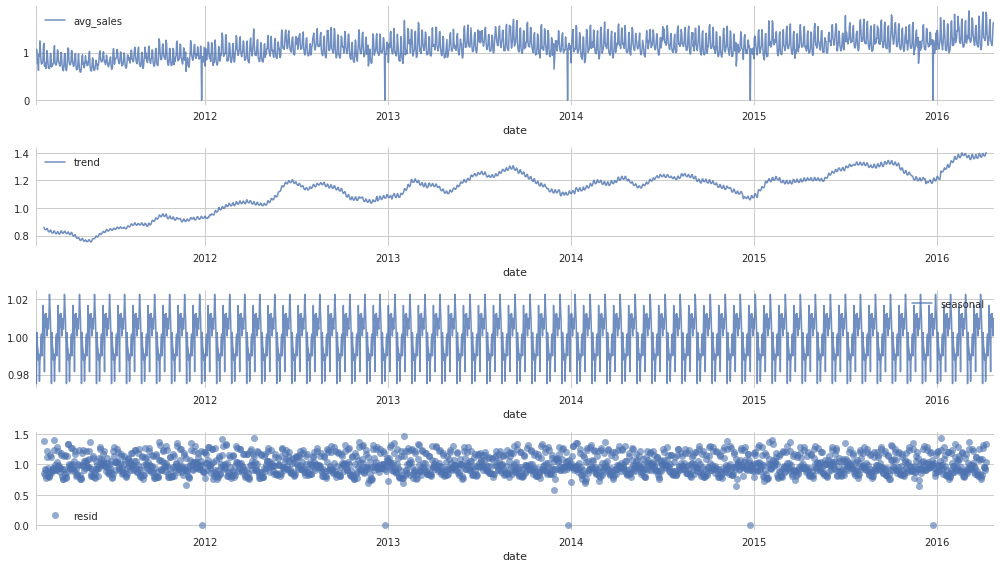

In [112]:
trend_comp, seas_comp, residual_comp = time_series_decompose(train_sales_cal_df[['avg_sales']], 'multiplicative', 30)

The above results indicate that the presence of an increasing trend, as well as high seasonality in the time series being observed. The **residuals** are infact the component of the time series *without the seasonality and trend.*

Let's see what the results of the dickey-fuller test in decomposition are

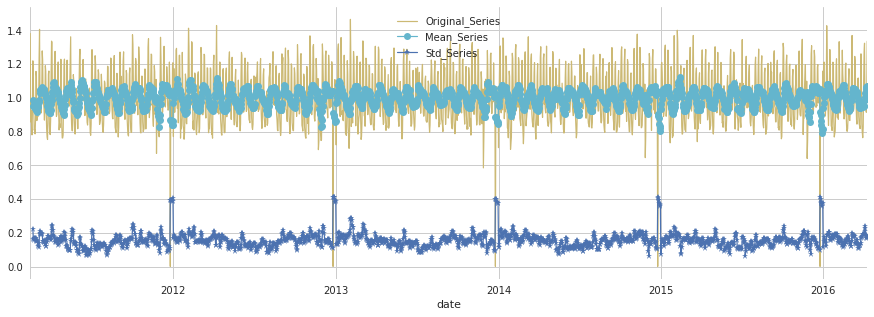


============++++==========

Results of the Dickey_Fuller Test
ADF Statistic: -26.316735
No of lags: 25.000000
No of Obs used for ADF Calculation & Critical Values: 1857.000000
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [113]:
residual_comp = residual_comp.dropna()
time_series_stationary_test(residual_comp)

The test statistic is less than 1 % of the critical value so we reject the null hypothesis with 99 % confidence and therefore, the time series is stationary

#### **SARIMAX**
SARIMAX (Seasonal Auto-Regressive Integrated Moving Averages With Exogenous Factors) is an extension of the ARIMA model but one that is able to handle the seasonality component along with exogenous factors. i.e. holidays.

ARIMA forecasting for a stationary time series is nothing but a regression equation. The prediction on the arima model is determined by its 'Trend' parameters p,d and q. They represent:

Number of AR (auto-regressive) terms (p) : AR terms are just lags of the dependent variable. e.g. if p is 2, the predictors for x(t) will be x(t-1), x(t-2) OR AR terms view the value at one time as a weighted sum of past values.
Number of MA (moving averages) terms (q) : MA terms are lagged forecast errors e(i) in prediction equation where e(i) is the difference between the moving avg at ith term vs the actual value. For q = 2, the predictors for x(t) will be e(t-1), e(t-2).
Number of differences (d) : These are the number of non-seasonal differences.
The SARIMAX adds other seasonal components to handle the seasonality with P, D, Q and m represpresenting the seasonal 'Auto-regressive' 'Differencing' and 'Moving-Average' Orders with m representing the number of time steps that are observing the seasonal behaviour.

The equation for SARIMAX is given as SARIMAX (p, d, q) = (P, D, Q, S)

To find out the appropriate values for p and q, we generally employ ACF (auto-correlation function) and PCF (Partial-correlation function).

ACF - AutoCorrelationFunction: It is the measure of the correlation of a time series against lagged version of itself. e.g. with a lag of 3, ACF would compare the time instances t1, t2 with t1-3, t2-3
PCF - PartialCorrelationFunction: It is a measure of correlation of a time series against a lagged version of itself but after removing the already calculated variations. e.g. with a lag of 4, PCF would check the correlation of against the lagged version but after removing the effects explained by lag1 to lag3

In [114]:
df_log_diff = np.log(train_sales_cal_df['avg_sales']) - np.log(train_sales_cal_df['avg_sales']).shift()
df_log_diff = df_log_diff.dropna()

### ACF & PACF: Finding Pdq Visually?

In [115]:
from statsmodels.tsa.stattools import acf, pacf

def auto_par_corr(ts_stat, nlags=25): 

    '''
    returns the ACF and PACF plots of the time series
    
    inputs: ts_stat (time series along with data), nlags (optimal number of lags)
    
    returns: plot of ACF and PACF
    '''
    lag_acf = acf(ts_stat, nlags)
    lag_pacf = pacf(ts_stat, nlags, method='ols')
    
    sns.set_style("whitegrid")

    
    plt.figure(figsize=(15, 8))
    plt.subplot(121)
    #plt.plot(lag_acf)
    plt.stem(lag_acf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Auto-Correlation')
    
    #lag_pacf.plot(figsize=(15, 5), alpha=1, 
    #                    lw=3, color=next(color_cycle), label='par_corr', ax=ax2)
    plt.subplot(122)
    #plt.plot(lag_pacf)
    plt.stem(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='g')
    plt.axhline(y=-1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.axhline(y=1.96/np.sqrt(len(ts_stat)), linestyle='--',color='r')
    plt.title('Partial Auto-Correlation')
    
    plt.legend()
    plt.show()
    

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.

/home/explore-student/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

/home/explore-student/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to Tru

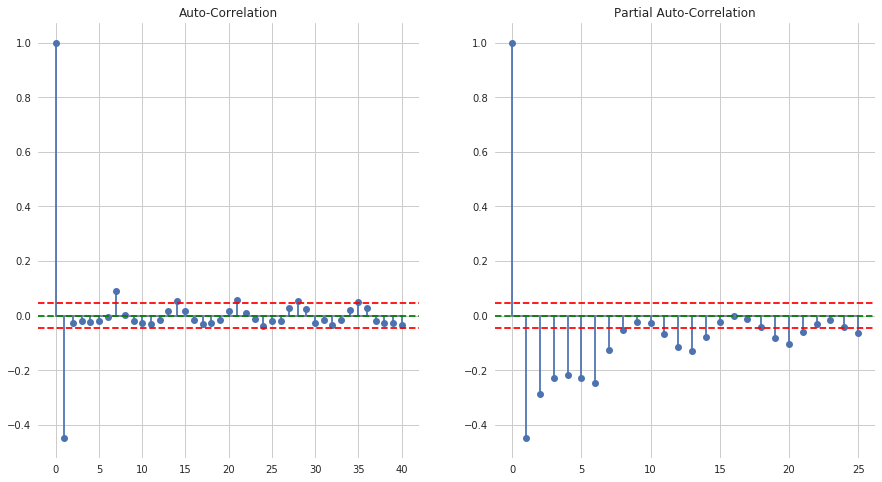

In [116]:
auto_par_corr(df_log_diff, nlags=25)

A couple of things of note here are :

* In the first plot of autocorreation, the first significant value occurs at between 1 and 2, so therefore we are going to select q=1, while in the second plot of PACF, the significant value occurs at 2 so p=2
* In the ACF plot, we have regular peaks at interval of 7 so we are going to select the value of parameter m in seasonal order as 7, and since this lag is positive therefore the value for P=1, and for Q=0.
* As for value of d (differencing), we are going to select d as being 1 since we have taken a first order differencing, and since our seasonal pattern in ACF plot is stable we are going to choose value of D=1 (as opposed to D=0 when seasonal pattern is unstable) 

In [117]:
train_sales_cal_df.index = pd.DatetimeIndex(train_sales_cal_df.index.values,
                               freq=train_sales_cal_df.index.inferred_freq)

In [118]:
#Let us split the time series into training and testing sets
#perc_training = 0.7
#split_p = round(len(train_sales_cal_df['avg_sales']) * perc_training)
#training_p, testing_p = train_sales_cal_df['avg_sales'][0:split_p], train_sales_cal_df['avg_sales'][split_p:]

training_p = train_sales_cal_df.loc[:'2015-10-14', ['avg_sales']]
testing_p = train_sales_cal_df.loc['2015-10-15':, ['avg_sales']]
training_p.head(2)

avg_sales
2011-01-29   1.070220
2011-01-30   1.041292

#### Making Exogeneous Factors

In [119]:
#for prophet model:
df_event_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': df_calendar[~df_calendar['event_name_1'].isna()]['date']})
df_event_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': df_calendar[~df_calendar['event_name_2'].isna()]['date']})
df_snapca = pd.DataFrame({'holiday': 'snap_CA', 'ds': df_calendar[df_calendar['snap_CA'] == 1]['date']})
df_snaptx = pd.DataFrame({'holiday': 'snap_TX', 'ds': df_calendar[df_calendar['snap_TX'] == 1]['date']})
df_snapwi = pd.DataFrame({'holiday': 'snap_WI', 'ds': df_calendar[df_calendar['snap_WI'] == 1]['date']})
holidays = pd.concat((df_event_1, df_event_2, df_snapca, df_snaptx, df_snapwi))
holidays.head(3)

holiday         ds
8   Event 1 2011-02-06
16  Event 1 2011-02-14
23  Event 1 2011-02-21

In [120]:
#ever since spliting exo, it is to be added additionally
holidays['ds'] = pd.to_datetime(holidays['ds'])

In [121]:
# for SARIMAX Model:

data = {'date':train_sales_cal_df.index,
        'holidays': 0 }

exo = pd.DataFrame(data)

for idx, date1 in enumerate(exo['date']):
    for date2 in holidays['ds']:
        if date2 == date1:
            exo['holidays'].iloc[idx] = 1
        else:
            continue 

In [122]:
exo = exo.set_index(['date']).asfreq('D')
exo.head(4)

holidays
date                
2011-01-29         0
2011-01-30         0
2011-01-31         0
2011-02-01         1

In [123]:
exo_train = exo.loc[:'2015-10-14']
exo_test = exo.loc['2015-10-15':]

In [124]:
#Conversion into Series according to SARiMAX req:
#conversion into timeseries if required, for now there is neither benefit nor requirement
exo_train = pd.Series(exo_train.iloc[:, 0])
exo_test = pd.Series(exo_test.iloc[:, 0])

In [125]:
def SARIMAX_tune(ts, total_params):

    '''
    returns the optimal tuned results using AIC as a prediction accuracy metric
    
    inputs : ts (time series), total_params (SARIMAX models parameters to be specified)
    
    returns: results of SARIMAX tuned model
    '''
    results = []

    for param in total_params:
        try:
            model = SARIMAX(ts, exog = exo, order=param[0], seasonal_order=param[1], 
                           initialization='approximate_diffuse')
            res = model.fit(method='powell')
            results.append((res, res.aic, res.params))
            print("The results of SARIMAX{}x{} in AIC are: {}".format(param[0], param[1], res.aic))
        except Exception as e:
            print(e)
            continue
    
    return results

In [126]:
###########New Code#############
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

def SARIMAX_tune_with_RMSE(ts, total_params):
    
    '''
    returns the optimal tuned results using RMSE as a prediction error metric
    
    inputs : ts (time series), total_params (SARIMAX models parameters to be specified)
    
    returns: results of SARIMAX tuned model with RMSE as the error metric
    '''
    tscv = TimeSeriesSplit(n_splits = 5)
    rmse_array = []
    timeseries = ts #train_sales_cal_df[['avg_sales']]
    results = []
    
    for train_index, test_index in tscv.split(timeseries):
        cv_train, cv_test = timeseries.iloc[train_index], timeseries.iloc[test_index]
        
        for param in total_params:
            try:
                model = SARIMAX(cv_train, order=param[0], seasonal_order=param[1], 
                               initialization='approximate_diffuse')
                res = model.fit(method="powell")
                results.append((res, res.params))
                #use this statement for further troubleshooting on mle #print("MLE retvals for this iter are: {}".format(res.mle_retvals))
                #print("The results of SARIMAX{}x{} in are: {}".format(param[0], param[1]))
            except Exception as e:
                print(e)
                continue

            sarimax = model.fit(disp=0)
            predictions = sarimax.predict(cv_test.index.values[0], cv_test.index.values[-1])
            true_values = cv_test.values
            #true_values = cv_test
            #wrmse_array.append(wrmse(true_values, predictions))
            #rmse_array.append(np.sqrt(mean_squared_error(true_values, predictions)))
            print("Results of SARIMAX in {} x {} in RMSE: {}".format(param[0], param[1], 
                                                                 np.sqrt(mean_squared_error(true_values, predictions))))
        
        return results

### The Accuracy Metric AIC: 

Since the **AIC (Akaike-Information Criterion)** is given by the difference of number of paramters vs log-likelihood of the model, it is therefore desirable to select the values of AIC that are as small (or in the current case) as negative as possible. 
The formula for the AIC is :

*  **AIC = 2K - ln(k)**

where k is the number of parameters for the selection of the model

Since the combination for pdq in our case tends to come out as 2,1,1 and for seasonal_PDQ as 0,1,2,7 Therefore, we are going to select those values 

### Validation SARIMAX

In [127]:
p, d, q =range(1,3), [1], range(1,3)
P, D, Q, S =range(0,3), [1], range(1,3), [7]
pdq = list(itertools.product(p,d,q))
seasonal_pdq = list(itertools.product(P,D,Q,S))
total_params = list(itertools.product(pdq, seasonal_pdq))

#NOTE: memory intensive operation if range set at 0,3, readings have already been taken by running it once:
#all_results = SARIMAX_tune(train_sales_cal_df['avg_sales'], total_params)
#all_results = SARIMAX_tune_with_RMSE(train_sales_cal_df[['avg_sales']], total_params)

#More information regarding fixng the error nle_retvals can be found at:
#https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax

In [128]:
all_results = SARIMAX_tune_with_RMSE(train_sales_cal_df[['avg_sales']], total_params)

Optimization terminated successfully.
         Current function value: -0.980493
         Iterations: 5
         Function evaluations: 295


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 1) x (0, 1, 1, 7) in RMSE: 0.1502060773205032
Optimization terminated successfully.
         Current function value: -0.828444
         Iterations: 5
         Function evaluations: 329


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 1) x (0, 1, 2, 7) in RMSE: 0.1347630895983486
Optimization terminated successfully.
         Current function value: -0.992579
         Iterations: 5
         Function evaluations: 366


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 1) x (1, 1, 1, 7) in RMSE: 0.15621640437520962
Optimization terminated successfully.
         Current function value: -0.828436
         Iterations: 7
         Function evaluations: 566


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 1) x (1, 1, 2, 7) in RMSE: 0.1715022993621842
Optimization terminated successfully.
         Current function value: -0.844557
         Iterations: 5
         Function evaluations: 496


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 1) x (2, 1, 1, 7) in RMSE: 0.12771481745725535
Optimization terminated successfully.
         Current function value: -0.827860
         Iterations: 8
         Function evaluations: 797


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 1) x (2, 1, 2, 7) in RMSE: 0.1746461872436811
Optimization terminated successfully.
         Current function value: -0.969266
         Iterations: 6
         Function evaluations: 425


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 2) x (0, 1, 1, 7) in RMSE: 0.12793404048593562
Optimization terminated successfully.
         Current function value: -0.790695
         Iterations: 7
         Function evaluations: 566


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 2) x (0, 1, 2, 7) in RMSE: 0.1330911995373899
Optimization terminated successfully.
         Current function value: -0.973266
         Iterations: 6
         Function evaluations: 558


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 2) x (1, 1, 1, 7) in RMSE: 0.1342005144924307
Optimization terminated successfully.
         Current function value: -0.790689
         Iterations: 8
         Function evaluations: 728


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 2) x (1, 1, 2, 7) in RMSE: 0.13424781586535178
Optimization terminated successfully.
         Current function value: -0.840261
         Iterations: 9
         Function evaluations: 944


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (1, 1, 2) x (2, 1, 1, 7) in RMSE: 0.12730361494180212
Optimization terminated successfully.
         Current function value: -0.790689
         Iterations: 14
         Function evaluations: 1574


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Results of SARIMAX in (1, 1, 2) x (2, 1, 2, 7) in RMSE: 0.13154896762299
Optimization terminated successfully.
         Current function value: -0.982166
         Iterations: 7
         Function evaluations: 593


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Results of SARIMAX in (2, 1, 1) x (0, 1, 1, 7) in RMSE: 0.14377499840501026
Optimization terminated successfully.
         Current function value: -0.846526
         Iterations: 14
         Function evaluations: 1103


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Results of SARIMAX in (2, 1, 1) x (0, 1, 2, 7) in RMSE: 0.1341110097106637
Optimization terminated successfully.
         Current function value: -0.992602
         Iterations: 7
         Function evaluations: 670


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Results of SARIMAX in (2, 1, 1) x (1, 1, 1, 7) in RMSE: 0.1271484961445722
Optimization terminated successfully.
         Current function value: -0.828939
         Iterations: 10
         Function evaluations: 996


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Results of SARIMAX in (2, 1, 1) x (1, 1, 2, 7) in RMSE: 0.14234924016173084
Optimization terminated successfully.
         Current function value: -0.826943
         Iterations: 8
         Function evaluations: 856


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Results of SARIMAX in (2, 1, 1) x (2, 1, 1, 7) in RMSE: 0.1276562652604096
Optimization terminated successfully.
         Current function value: -0.828267
         Iterations: 9
         Function evaluations: 1073


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (2, 1, 1) x (2, 1, 2, 7) in RMSE: 0.17129061573480772
Optimization terminated successfully.
         Current function value: -0.999673
         Iterations: 13
         Function evaluations: 1082


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (2, 1, 2) x (0, 1, 1, 7) in RMSE: 0.13294942824024988
Optimization terminated successfully.
         Current function value: -0.823652
         Iterations: 10
         Function evaluations: 975


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (2, 1, 2) x (0, 1, 2, 7) in RMSE: 0.13374655053953124
Optimization terminated successfully.
         Current function value: -1.005279
         Iterations: 14
         Function evaluations: 1459


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (2, 1, 2) x (1, 1, 1, 7) in RMSE: 0.12817207865531344
Optimization terminated successfully.
         Current function value: -0.824132
         Iterations: 14
         Function evaluations: 1480


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (2, 1, 2) x (1, 1, 2, 7) in RMSE: 0.13397129861667686
Optimization terminated successfully.
         Current function value: -0.849053
         Iterations: 12
         Function evaluations: 1473


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



Results of SARIMAX in (2, 1, 2) x (2, 1, 1, 7) in RMSE: 0.14696368877059268
Optimization terminated successfully.
         Current function value: -0.817671
         Iterations: 11
         Function evaluations: 1424
Results of SARIMAX in (2, 1, 2) x (2, 1, 2, 7) in RMSE: 0.13214440805560865


/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



In [129]:
#Fitting in the SARIMAX Model
#include the exo_train in here , exo_test in prediction (model_fit_SARIMAX) to check results: for now, abandoning their use because
# of the error in package, since even converting exo_train, exo_test into time series/using df results
# in errors. 
#model values earlier 1,1,1, 0,1,1,7 
#values with RMSE - order=(2,1,1), seasonal_order=(2,1,1,7), 
model = SARIMAX(training_p,
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)
print(model_fit.summary())
#model_fit.plot_diagnostics(figsize=(15,7))
#plt.show()
#information on whether particular model is a goodfit
#https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

                                     SARIMAX Results                                     
Dep. Variable:                         avg_sales   No. Observations:                 1720
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood                1485.773
Date:                           Sun, 09 Oct 2022   AIC                          -2957.546
Time:                                   15:41:19   BIC                          -2919.494
Sample:                               01-29-2011   HQIC                         -2943.457
                                    - 10-14-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3602      0.013     26.953      0.000       0.334       0.386
ar.L2          0.1133      0.022      5.091

The above plots confirm the inferences of the following information:
- The first left plot shows that residual errors fluctuate around a mean of zero and have uniform variance
- The first right plot indicates that density plot also has a mean of almost zero
- The second left plot indicate an almost a perfect fit on red line pointing to the fact that distribution is not skewed
- The low auto-correlation of residuals is indicated in the second right plot. 

### SARIMAX Graphical Validation & Forecasting

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



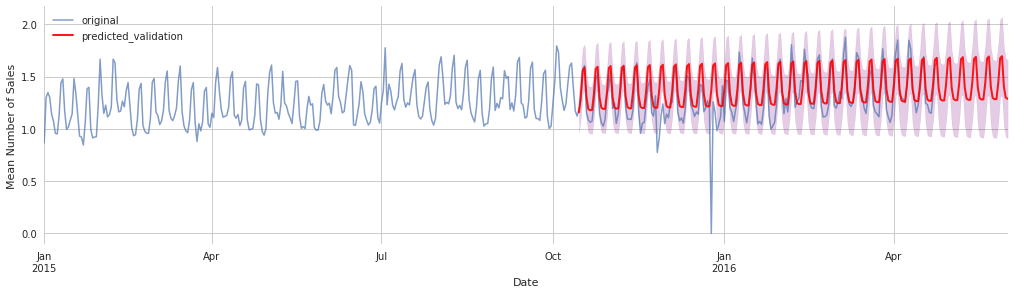

In [130]:
def model_fit_SARIMAX(model_set, model_fit_srt_tm='2015-10-15', ts_st_tm='2013'):
    
    '''
    makes predictions using SARIMAX model tuned earlier and returns plots along with 
    predictions made
    
    inputs: model_set (model tuned), model_fit_srt_tm (model prediction starting time), 
            ts_st_tm (time series plot to be plotted beginning point)
    returns: forecast plot along with time_series, and pred (predictions made series)
    
    '''
    
    #1.# pred = model_fit.forecast(len(testing_p), alpha=0.05, dynamic=False)  # 95% conf
    pred = model_set.get_prediction(start=pd.to_datetime(model_fit_srt_tm), end='2016-06-01', dynamic=False)
    pred_conf = pred.conf_int()
    #for dynamic prediction of time_series:
    #pred_dy = model_set.get_prediction(dynamic=pred_srt_tm)
    #pred_dy_conf = pred_dy.conf_int()

    # Make as pandas series
    #pred_series = pd.Series(pred, index=testing_p.index)

    sns.set_style('whitegrid')
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))

    train_sales_cal_df['avg_sales'][ts_st_tm:].plot(label='original',
                                                  alpha=0.7, 
                                                  lw=1.5 , ax=ax1)
    pred.predicted_mean.plot(label='predicted_validation',
                             alpha=0.9, color='red',
                             lw=2, ax=ax1)
    ax1.fill_between(pred_conf.index, 
                     pred_conf.iloc[:,0], 
                     pred_conf.iloc[:, 1], color='purple', alpha=0.2)
    fig.tight_layout()
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Number of Sales')
    plt.legend(loc='upper left')
    plt.show()
    
    return pred

pred_made = model_fit_SARIMAX(model_fit, ts_st_tm='2015')    

Looking at the above graphical representation, we can see that: 
- Our model (indicated by red line) provides quite a good enough approximation for modeling the time_series behavior with the maroon background indicating a confidence interval for the new predicted time series. 
- We have applied the model on the test_dataset (data already present in our time series). In the next step, we would try to predict this time series response in the future

In [131]:
def forecast_error(prediction, original, date, col):
    
    '''
    returns the Mean Absolute Error (MAE) and root mean square error (RMSE)
    inputs: prediction (forecasted series, with dates as predicted above), original (orginal time series df), 
    date (where the model was started for forecast), col(column with time_series_values)
    returns : MAE, and RMSE 
    '''
    forecasted = prediction.predicted_mean
    original = original.loc[date:, col]
    MAE = np.abs(forecasted - original).mean()
    RMSE = np.sqrt(((forecasted - original)**2).mean())
    print("The mean absolute error is : {}".format(MAE))
    print("The root mean square error is : {}".format(RMSE))
    forecast_error(pred_made, testing_p, '2015-10-15', 'avg_sales')    

In [132]:
#fitting the model once again now to all the timeseries data (train_sales_cal_df['avg_sales']) available:
#old_values - 2,1,1 & 0,1,2,7
model = SARIMAX(train_sales_cal_df['avg_sales'],
                order=(2,1,1), seasonal_order=(2,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=0)

/home/explore-student/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



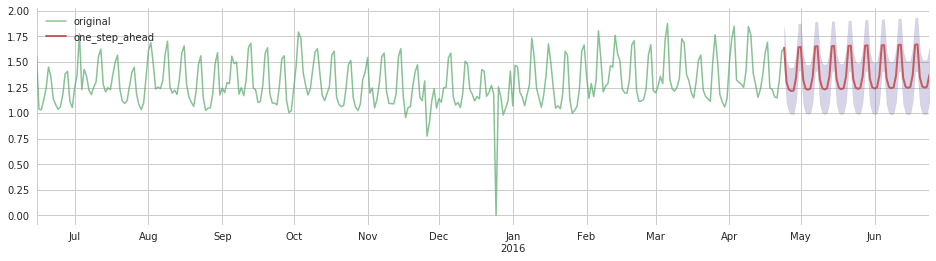

In [133]:
#Making Future Prediction:
#note: exo_sub = exo.loc['2016-01-25':], if it is needed to provide the holidays , equate exo_sub to exog in get forecast

#pred_future = model_fit.get_forecast(steps=90) #Making Prediction for next 3 months

pred_future = model_fit.get_prediction(start='2016-04-24', end='2016-06-24', dynamic=False)
pred_f_conf = pred_future.conf_int()

fig, ax2 = plt.subplots(figsize=(16, 4))


#now using the entire original series, instead of training or testing:

train_sales_cal_df['avg_sales']['2015-06-15':].plot(label='original',
                 alpha=0.7, 
                 lw=1.5 , color=next(color_cycle), ax=ax2)

pred_future.predicted_mean.plot(label='one_step_ahead',
                 alpha=0.9, 
                 lw=2, color=next(color_cycle), ax=ax2)

ci = pred_f_conf.loc['2016-04-24':]

ax2.fill_between(ci.index, 
                ci.iloc[:,0], 
                ci.iloc[:, 1], color=next(color_cycle), alpha=0.3)

plt.legend(loc='upper left')
plt.show()

The 'original' label represents the timeseries data for which we have the data of average sales available. Whereas the 'one_ahead_label' indicates the forecast made for the time series of average sales, AND the filled background indicates the confidence interval. 

The Forecast is a fairly good response of average number of sales that would be made into the future.

### WRMSSE Calculation

In order to measure the performance of the model, the competition metric has been provided already. This competiton metric can be found at the guidlines provided in the following link. 

WRMSSE is a sales metric that derives itself from RMSSE metric which is a variation on the metric of MASE (mean absolute scaled error). RMSSE specifically evaluate the sales forecast for datasets where heirarchical data level is made available. Since the first dataset of train_sales_val has heirarchical sales data available (i.e.sales divided along product_ids, item_ids, dept_ids, and store_ids level) and one that is also intermittent (i.e. has greater incidence of zero sales in some days while significant sales in other days), RMSSE's utility makes sense. The RMSSE metric also penalizes too large or too small values, therefore it is symmetric. 

\begin{equation}
WRMSSE = \sum_{i=1}^{42840} \left(\frac{W_i}{\sqrt{S_i}} \times \sqrt{\sum{(D)^2}}\right)
\end{equation}

Note: Difference in rolled up vectors is equal to their rolled up difference:
\begin{equation}
Y×M−Y^×M=(Y−Y^)×M=D
\end{equation}

where Y_t is the actual future value of the examined time series at point t, (Y_t ) is the generated forecast, n the length of the training sample (number of historical observations), and h the forecasting horizon. 



In [134]:
gc.collect()
del df

In [135]:
from scipy.sparse import csr_matrix


NUM_ITEMS = df_sales_train.shape[0]  # 30490
DAYS_PRED = df_sample_submission.shape[1] - 1  # 28

# Dataframe with only last 28 days:
sales = df_sales_train
cols = ["d_{}".format(i) for i in range(1914-28, 1914)]
data = sales[["id", 'store_id', 'item_id'] + cols]

# To long form:
data = data.melt(id_vars=["id", 'store_id', 'item_id'], 
                 var_name="d", value_name="sale")

# Add week of year column from 'calendar':
data = pd.merge(data, df_calendar, how = 'left', 
                left_on = ['d'], right_on = ['d'])

data = data[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

# Add weekly price from 'sell_prices':
data = data.merge(df_sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
data.drop(columns = ['wm_yr_wk'], inplace=True)

# Calculate daily sales in USD:
data['sale_usd'] = data['sale'] * data['sell_price']
data = reduce(data)
data.head()

#this part is correct

id store_id        item_id  sale       d  \
0  HOBBIES_1_001_CA_1_validation     CA_1  HOBBIES_1_001     1  d_1886   
1  HOBBIES_1_002_CA_1_validation     CA_1  HOBBIES_1_002     1  d_1886   
2  HOBBIES_1_003_CA_1_validation     CA_1  HOBBIES_1_003     0  d_1886   
3  HOBBIES_1_004_CA_1_validation     CA_1  HOBBIES_1_004     0  d_1886   
4  HOBBIES_1_005_CA_1_validation     CA_1  HOBBIES_1_005     1  d_1886   

   sell_price category  sale_usd  
0    8.257812  HOBBIES  8.257812  
1    3.970703  HOBBIES  3.970703  
2    2.970703  HOBBIES  0.000000  
3    4.640625  HOBBIES  0.000000  
4    2.880859  HOBBIES  2.880859

In [ ]:
# List of categories combinations for aggregations as defined in docs:
dummies_list = [sales.state_id, sales.store_id, 
                sales.cat_id, sales.dept_id, 
                sales.state_id +'_'+ sales.cat_id, sales.state_id +'_'+ sales.dept_id,
                sales.store_id +'_'+ sales.cat_id, sales.store_id +'_'+ sales.dept_id, 
                sales.item_id, sales.state_id +'_'+ sales.item_id, sales.id]


## First element Level_0 aggregation 'all_sales':
dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
                               index=sales.index, columns=['all']).T]

# List of dummy dataframes:
for i, cats in enumerate(dummies_list):
    dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
# Concat dummy dataframes in one go:
## Level is constructed for free.
roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
                        names=['level','id'])#.astype(np.int8, copy=False)

# Save values as sparse matrix & save index for future reference:
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
roll_mat_csr.shape

roll_mat_df.to_pickle('roll_mat_df.pkl')
del dummies_df_list, roll_mat_df

In [ ]:
"""roll_mat_df.to_pickle('roll_mat_df.pkl')
del dummies_df_list, roll_mat_df
gc.collect()"""

In [ ]:
# Fucntion to calculate S weights:
def get_s(drop_days=0):
    
    """
    drop_days: int, equals 0 by default, so S is calculated on all data.
               If equals 28, last 28 days won't be used in calculating S.
    """
    # Rollup sales:
    d_name = ['d_' + str(i+1) for i in range(1913-drop_days)]
    sales_train_val = roll_mat_csr * sales[d_name].values

    no_sales = np.cumsum(sales_train_val, axis=1) == 0
    sales_train_val = np.where(no_sales, np.nan, sales_train_val)

    # Denominator of RMSSE / RMSSE
    weight1 = np.nanmean(np.diff(sales_train_val,axis=1)**2,axis=1)
    
    return weight1

In [ ]:
S = get_s(drop_days=0)
S.shape

In [ ]:
# Functinon to calculate weights:
def get_w(sale_usd):
    """
    """
    # Calculate the total sales in USD for each item id:
    total_sales_usd = sale_usd.groupby(
        ['id'], sort=False)['sale_usd'].apply(np.sum).values
    
    # Roll up total sales by ids to higher levels:
    weight2 = roll_mat_csr * total_sales_usd
    
    return 12*weight2/np.sum(weight2)

In [ ]:
W = get_w(data[['id','sale_usd']])
W.shape

In [ ]:
# Predicted weights
##W_df = pd.DataFrame(W,index = roll_index,columns=['w'])

# Load the original weights:
##data_pass = '/kaggle/input/original-weights/'
##W_original_df = pd.read_csv(data_pass+'weights_validation.csv')

# Set new index, calculate difference between original and predicted:
##W_original_df = W_original_df.set_index(W_df.index)
##W_original_df['Predicted'] = W_df.w
##W_original_df['diff'] = W_original_df.Weight - W_original_df.Predicted

# See where we are off by more than e-6
##m = W_original_df.Weight.values - W_df.w.values > 0.000001
##W_original_df[m]

In [ ]:
SW = W/np.sqrt(S)
sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
sw_df.to_pickle('sw_df.pkl')

In [ ]:
# Function to do quick rollups:
def rollup(v):
    '''
    v - np.array of size (30490 rows, n day columns)
    v_rolledup - array of size (n, 42840)
    '''
    return roll_mat_csr*v #(v.T*roll_mat_csr.T).T


# Function to calculate WRMSSE:
def wrmsse(preds, y_true, score_only=False, s = S, w = W, sw=SW):
    '''
    preds - Predictions: pd.DataFrame of size (30490 rows, N day columns)
    y_true - True values: pd.DataFrame of size (30490 rows, N day columns)
    sequence_length - np.array of size (42840,)
    sales_weight - sales weights based on last 28 days: np.array (42840,)
    '''
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw)/12 #<-used to be mistake here
    else: 
        score_matrix = (np.square(rollup(preds.values-y_true.values)) * np.square(w)[:, None])/ s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix,axis=1)))/12 #<-used to be mistake here
        return score, score_matrix

### Final Submission File Preparation

In [ ]:
# Fix negative forecast
num = df_sample_submission._get_numeric_data()
num[num < 0] = 0
# Prepare the submission file
df_sample_submission.to_csv('submission.csv', index=False)

print(f'Submission shape: {df_sample_submission.shape}')